## Data Import

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
plt.rcdefaults()


from google.colab import drive
drive.mount('/content/drive', force_remount=True)

df = pd.read_csv("/content/drive/MyDrive/df_clustering.csv")
function_package = pd.read_csv("/content/drive/MyDrive/function_package_table.csv")

# Drop duplicates in the function_package table
function_package = function_package.drop_duplicates(subset=["idFunction"])

# merge
df = df.merge(
    function_package[["idFunction", "namePackage"]],
    on="idFunction",
    how="left"
)

# Convert types
df["idFunction"] = df["idFunction"].astype("category")
df["resultNormalized"] = df["resultNormalized"].astype("category")
df["dateValue"] = pd.to_datetime(df["dateValue"], errors="coerce")
df["age_at_first_test"] = df["age_at_first_test"].astype("float")
df["is_male"] = df["is_male"].astype("category")
df["studies"] = df["studies"].astype("category")
df["ethiology"] = df["ethiology"].astype("category")
df["origin_type"] = df["origin_type"].astype("category")
df["profile"] = df["profile"].astype("category")
df["namePackage"] = df["namePackage"].astype("category")

print(df.shape)
df.head()

Mounted at /content/drive
(355940, 11)


,idTreatment,idFunction,resultNormalized,dateValue,age_at_first_test,is_male,studies,ethiology,origin_type,profile,namePackage
0,5231,9,2.0,2013-02-08,70.0,0.0,1.0,-1.0,equalizer,8.0,Visual
1,5231,8,1.0,2013-02-08,70.0,0.0,1.0,-1.0,equalizer,8.0,Verbal
2,5231,87,1.0,2013-02-08,70.0,0.0,1.0,-1.0,equalizer,8.0,Temporoespacial
3,5231,85,2.0,2013-02-08,70.0,0.0,1.0,-1.0,equalizer,8.0,Visuales
4,5231,83,3.0,2013-02-08,70.0,0.0,1.0,-1.0,equalizer,8.0,Mental


In [181]:
subfunctions = pd.read_csv("/content/drive/MyDrive/subfunctions.csv")
# Merge subfunctions with function_package_table to get the macro domain name
subfunctions = subfunctions.merge(
    function_package[["idFunction", "namePackage"]],
    how="left",
    left_on="idParent",
    right_on="idFunction"
)
subfunctions = subfunctions.rename(columns={"namePackage": "macro_domain"})
# Merge df with the mapping
df = df.merge(
    subfunctions[["idChild", "macro_domain"]],
    how="left",
    left_on="idFunction",
    right_on="idChild"
)

df = df.drop(columns=["idChild"])
# Print microdomains (functions) for each macro domain
for domain in sorted(df["macro_domain"].dropna().unique()):
    print(f"\nMacro domain: {domain}")
    functions_list = df[df["macro_domain"] == domain][["idFunction", "namePackage"]].drop_duplicates()
    print(functions_list)


Macro domain: Animacions
       idFunction namePackage
994           158    Enanitos
996           161       Gatos
1000          163      Merlin
1004          154       Bruja
1006          165       Patos
14994         215       Patos
14995         214      Merlin
14997         213       Gatos
14999         212    Enanitos
15013         211       Bruja

Macro domain: Atencio
       idFunction namePackage
10              5  Sostinguda
11              6   Selectiva
12              7    Dividida
16             48  Sostinguda
21             53    Dividida
23             51   Selectiva
27            102    Dividida
28            101   Selectiva
29            100  Sostinguda
60             27   Selectiva
79             26  Sostinguda
86             28    Dividida
847            68  Sostinguda
993           152  Sostinguda
1003          149   Selectiva
1451          114    Dividida
1452          113   Selectiva
1453          112  Sostinguda
1679           66    Dividida
1681           67   S

There are some misclassifications in the 'Lenguaje' domain (e.g., 'Memoriaverbal' and 'Cognitivesbasiques' functions). Manual corrections will be applied to reassign these functions to the appropriate macro domains.

In [182]:
manual_macro_fix = {
    295: "Memoria",               # Memoriaverbal
    296: "Memoria",               # Memoriaverbal
    297: "Memoria",               # Memoriaverbal
    276: "Funcionsexecutives",    # Cognitivesbasiques
    281: "Funcionsexecutives",    # Cognitivesbasiques
    293: "Funcionsexecutives",    # Cognitivesbasiques
}

# Apply manual corrections again with the updated mapping
df["macro_domain_corrected"] = df.apply(
    lambda row: manual_macro_fix[row["idFunction"]]
    if row["idFunction"] in manual_macro_fix
    else row["macro_domain"],
    axis=1
)

# Print microdomains (functions) for each corrected macro domain
for domain in sorted(df["macro_domain_corrected"].dropna().unique()):
    print(f"\nMacro domain: {domain}")
    functions_list = df[df["macro_domain_corrected"] == domain][["idFunction", "namePackage"]].drop_duplicates()
    print(functions_list)


Macro domain: Animacions
       idFunction namePackage
994           158    Enanitos
996           161       Gatos
1000          163      Merlin
1004          154       Bruja
1006          165       Patos
14994         215       Patos
14995         214      Merlin
14997         213       Gatos
14999         212    Enanitos
15013         211       Bruja

Macro domain: Atencio
       idFunction namePackage
10              5  Sostinguda
11              6   Selectiva
12              7    Dividida
16             48  Sostinguda
21             53    Dividida
23             51   Selectiva
27            102    Dividida
28            101   Selectiva
29            100  Sostinguda
60             27   Selectiva
79             26  Sostinguda
86             28    Dividida
847            68  Sostinguda
993           152  Sostinguda
1003          149   Selectiva
1451          114    Dividida
1452          113   Selectiva
1453          112  Sostinguda
1679           66    Dividida
1681           67   S

In [183]:
# Check which functions still have missing macro domain after the corrections
missing_macro = df[df["macro_domain_corrected"].isna()][["idFunction", "namePackage"]].drop_duplicates()

print("Functions without macro domain:")
print(missing_macro)

Functions without macro domain:
        idFunction          namePackage
235571          20  Comprensionauditiva
235573          19              Lectura
235587          18            Escritura
248080           0                  NaN
249404          41  Comprensionauditiva
249405          40              Lectura
249409          39            Escritura
263665          95          Orientacion
265968         132              Lectura
265970         131  Comprensionauditiva
265971         130            Escritura


 Manual corrections will be applied to assign these functions to the appropriate macro domains.

In [184]:
# Manual mapping for the missing macro domains. idFunction = 0 is excluded
manual_missing_fix = {
    20: "Lenguaje",              # Comprensionauditiva
    19: "Lenguaje",              # Lectura
    18: "Lenguaje",              # Escritura
    41: "Lenguaje",              # Comprensionauditiva
    40: "Lenguaje",              # Lectura
    39: "Lenguaje",              # Escritura
    132: "Lenguaje",             # Lectura
    131: "Lenguaje",             # Comprensionauditiva
    130: "Lenguaje",             # Escritura
    95: "Orientacion",           # Orientacion
}

# Combine the two manual fix dictionaries
final_manual_fix = {**manual_macro_fix, **manual_missing_fix}

# Apply the corrections
df["macro_domain_corrected"] = df.apply(
    lambda row: final_manual_fix[row["idFunction"]]
    if row["idFunction"] in final_manual_fix
    else row["macro_domain"],
    axis=1
)
# Check if there are still any missing macro domains after the corrections
missing_after_fix = df[df["macro_domain_corrected"].isna()][["idFunction", "namePackage"]].drop_duplicates()
print("Still missing after manual fix:")
print(missing_after_fix)

# Count how many rows still have missing macro domain after corrections
missing_count = df["macro_domain_corrected"].isna().sum()

print(f"Number of rows with missing macro domain: {missing_count}")

# Drop the old macro domain column
df= df.drop(columns=["macro_domain"])

Still missing after manual fix:
        idFunction namePackage
248080           0         NaN
Number of rows with missing macro domain: 26


## Missing Data Overview


Missing values per column:
idTreatment                  0
idFunction                   0
resultNormalized            29
dateValue                    0
age_at_first_test           83
is_male                   6120
studies                     83
ethiology                 2801
origin_type                  0
profile                   8863
namePackage                 26
macro_domain_corrected      26
dtype: int64

Percentage of missing values:
profile                   2.490026
is_male                   1.719391
ethiology                 0.786930
age_at_first_test         0.023319
studies                   0.023319
resultNormalized          0.008147
macro_domain_corrected    0.007305
namePackage               0.007305
dateValue                 0.000000
idFunction                0.000000
idTreatment               0.000000
origin_type               0.000000
dtype: float64


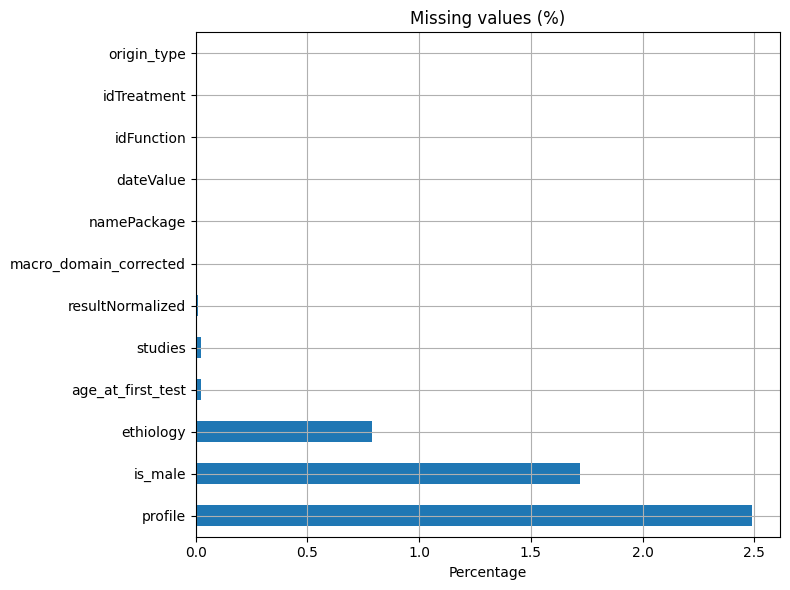

In [185]:
# Count missing values per column
print("\nMissing values per column:")
print(df.isnull().sum())

# Show percentage of missing values
print("\nPercentage of missing values:")
missing_pct = df.isnull().mean().sort_values(ascending=False) * 100
print(missing_pct)

# Plot missing values
missing_pct.plot(kind="barh", figsize=(8,6), title="Missing values (%)")
plt.xlabel("Percentage")
plt.grid()
plt.tight_layout()
plt.show()

The variable profile has the highest percentage of missing values (about 2.5%).
Since it will not be used for clustering but only for descriptive analyses, it will not be filled in the missing values.

Rows with missing values in resultNormalized, namePackage, age_at_first_test and studies will be removed because the missing percentage is very low.

The ethiology variable has only 0.78% missing values. Since the code -1 is already used in the data to indicate "undefined etiology," the missing values will be replaced with -1 (to check: is it acceptable to impute them as -1 ("No definida"), or should they all be excluded from the analysis? )

Missing values in is_male will be imputed using the observed gender distribution.

In [186]:
# Drop rows with few missing values
df = df.dropna(subset=["age_at_first_test", "studies", "resultNormalized", "namePackage"])

# Replace missing values in 'ethiology' with -1
df["ethiology"] = df["ethiology"].fillna(-1)

/tmp/ipython-input-186-1079794904.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ethiology"] = df["ethiology"].fillna(-1)


In [187]:
# Count proportion of male
p_male = (df["is_male"] == 1).sum() / df["is_male"].notna().sum()

print(f"Percentage of males (is_male == 1): {p_male * 100:.2f}%")

Percentage of males (is_male == 1): 57.29%


In [188]:
# Identify missing values in 'is_male'
missing_gender = df["is_male"].isnull()

# Replace missing values with random 1 or 0 based on observed probabilities (57.28%)
df.loc[missing_gender, "is_male"] = np.random.choice(
    [1, 0],
    size=missing_gender.sum(),
    p=[0.57, 0.43]
)

In [189]:
# Show percentage of missing values
print("\nPercentage of missing values:")
missing_pct = df.isnull().mean().sort_values(ascending=False) * 100
print(missing_pct)


Percentage of missing values:
profile                   2.467665
idTreatment               0.000000
resultNormalized          0.000000
idFunction                0.000000
dateValue                 0.000000
age_at_first_test         0.000000
studies                   0.000000
is_male                   0.000000
ethiology                 0.000000
origin_type               0.000000
namePackage               0.000000
macro_domain_corrected    0.000000
dtype: float64


## Descriptive Statistics

### AFFECTATION LEVEL


Affectation level distribution:
resultNormalized
-2.0    114597
 0.0     58779
 1.0     59380
 2.0     58512
 3.0     34263
 4.0     30271
Name: count, dtype: int64


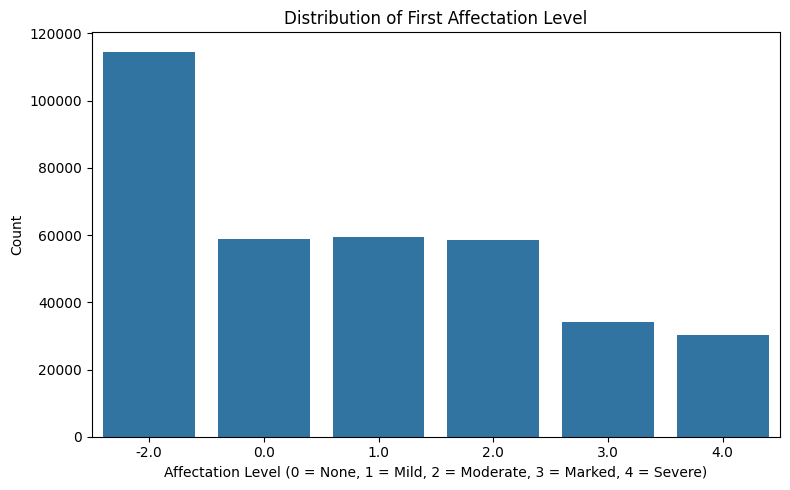

In [190]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of first_affectation_level
print("\nAffectation level distribution:")
print(df["resultNormalized"].value_counts().sort_index())

# Plot with black bars
plt.figure(figsize=(8,5))
sns.countplot(
    data=df,
    x="resultNormalized",
    order=sorted(df["resultNormalized"].unique())
)
plt.title("Distribution of First Affectation Level")
plt.xlabel("Affectation Level (0 = None, 1 = Mild, 2 = Moderate, 3 = Marked, 4 = Severe)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [191]:
# Filter only rows where resultNormalized is -2
minus2_functions = df[df["resultNormalized"] == -2]

# Count frequency of each function (idFunction) where -2 appears
function_counts = minus2_functions["idFunction"].value_counts(normalize=True).sort_values(ascending=False)

# Create a dataframe from the counts
function_counts_df = function_counts.reset_index()
function_counts_df.columns = ["idFunction", "percentage"]

# Keep both namePackage and macro_domain_correct
unique_functions = df[["idFunction", "namePackage", "macro_domain_corrected"]].drop_duplicates()

# Merge to get the namePackage and macro domain
function_counts_df = function_counts_df.merge(unique_functions, on="idFunction", how="left")

# Print the top 10 functions with their names and macro domains
print("Top cognitive functions where -2 appears most frequently:")
print(function_counts_df.head(10))


Top cognitive functions where -2 appears most frequently:
   idFunction  percentage          namePackage macro_domain_corrected
0          89    0.064190        Constructivas                Praxias
1          83    0.048884               Mental                Calculo
2          20    0.044844  Comprensionauditiva               Lenguaje
3          19    0.041877              Lectura               Lenguaje
4          18    0.040935            Escritura               Lenguaje
5         252    0.038806          Teoriamente        Socialcognition
6         251    0.038509  Emotionalprocessing        Socialcognition
7         250    0.038509      Cognitivebiases        Socialcognition
8          85    0.032086             Visuales                Gnosias
9           9    0.031484               Visual                Memoria


In [192]:
# Ensure that resultNormalized is numeric
df["resultNormalized"] = pd.to_numeric(df["resultNormalized"], errors="coerce")

# Count total functions per treatment
total_functions = df.groupby("idTreatment")["idFunction"].nunique()

# Count severe functions per treatment (resultNormalized >= 3) (to check)
severe_counts = df[df["resultNormalized"] >= 3].groupby("idTreatment")["idFunction"].nunique()

# Calculate percentage of severe functions
severe_percentage = severe_counts / total_functions

# Filter treatments where at least 30% of functions are severe
severe_treatments = severe_percentage[severe_percentage >= 0.30].index

# Map of severe functions for these treatments
severe_map = df[(df["idTreatment"].isin(severe_treatments)) & (df["resultNormalized"] >= 3)] \
    .groupby("idTreatment")["idFunction"].apply(set)

# Map of not evaluable functions (resultNormalized = -2) per treatment
minus2_map = df[df["resultNormalized"] == -2].groupby("idTreatment")["idFunction"].apply(set)

# Identify treatments that have both conditions
common_ids = severe_map.index.intersection(minus2_map.index)

# Print the first 50 examples
for tid in list(common_ids)[:50]:
    print(f"\nTreatment ID: {tid}")
    print(f"  Severe functions (>=3): {severe_map[tid]}")
    print(f"  Not evaluable functions (-2): {minus2_map[tid]}")


Treatment ID: 6
  Severe functions (>=3): {5, 6, 7, 8, 11, 13, 14, 15}
  Not evaluable functions (-2): {9, 18, 19, 83, 20, 89}

Treatment ID: 7
  Severe functions (>=3): {5, 6, 7, 11, 12, 13, 14}
  Not evaluable functions (-2): {9, 18, 19, 83, 20, 89}

Treatment ID: 10
  Severe functions (>=3): {6, 7, 11, 13, 14, 15}
  Not evaluable functions (-2): {9, 18, 83, 19, 20, 89}

Treatment ID: 11
  Severe functions (>=3): {5, 6, 7, 11, 12, 13, 14, 15}
  Not evaluable functions (-2): {9, 18, 83, 19, 20, 89}

Treatment ID: 15
  Severe functions (>=3): {6, 7, 8, 11, 12, 13, 14, 15}
  Not evaluable functions (-2): {9, 18, 83, 19, 20, 89}

Treatment ID: 19
  Severe functions (>=3): {5, 6, 7, 8, 10, 11, 12, 13, 14, 15}
  Not evaluable functions (-2): {9, 18, 83, 20, 19, 89}

Treatment ID: 20
  Severe functions (>=3): {5, 7, 11, 13, 14, 15}
  Not evaluable functions (-2): {9, 18, 83, 20, 19, 89}

Treatment ID: 21
  Severe functions (>=3): {5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 85, 87}
  Not evaluable

In treatments with ≥30% of severe functions (resultNormalized ≥ 3) we noticed that

- The same functions {9, 18, 19, 20, 83, 89} (Visual,Escritura,Lectura,Comprensionauditiva, Mental,Constructivas) are systematically marked as not evaluable (-2). This suggests that these functions are systematically non-evaluable in patients with severe impairment, and may therefore be particularly sensitive to clinical severity.

- These -2 functions belong to the same cognitive domains (Lenguaje, Gnosias, Calculo) that are often severely affected in these patients.

- The presence of -2 is not random in severe cases; it follows a  pattern.
  → This adds clinical credibility to the idea of recoding -2 as a fictitious level 5 (very severe impairment) in these specific contexts.

In [193]:
# Loop over the first 50 treatment IDs
for tid in list(common_ids)[:50]:
    severe_funcs = severe_map[tid]
    minus2_funcs = minus2_map[tid]

    # Get macro-domains for severe and -2 functions
    severe_domains = set(df[(df["idTreatment"] == tid) & (df["idFunction"].isin(severe_funcs))]["macro_domain_corrected"])
    minus2_domains = set(df[(df["idTreatment"] == tid) & (df["idFunction"].isin(minus2_funcs))]["macro_domain_corrected"])

    # Print results
    print(f"\nTreatment ID: {tid}")
    print(f"  Severe functions (>=3): {severe_funcs}")
    print(f"  Severe macro-domains: {severe_domains}")
    print(f"  Not evaluable functions (-2): {minus2_funcs}")
    print(f"  Not evaluable macro-domains: {minus2_domains}")

    # Optional: check if the domains overlap
    common_domains = severe_domains.intersection(minus2_domains)
    print(f"  Overlapping macro-domains: {common_domains if common_domains else 'None'}")



Treatment ID: 6
  Severe functions (>=3): {5, 6, 7, 8, 11, 13, 14, 15}
  Severe macro-domains: {'Memoria', 'Funcionsexecutives', 'Atencio'}
  Not evaluable functions (-2): {9, 18, 19, 83, 20, 89}
  Not evaluable macro-domains: {'Memoria', 'Calculo', 'Lenguaje', 'Praxias'}
  Overlapping macro-domains: {'Memoria'}

Treatment ID: 7
  Severe functions (>=3): {5, 6, 7, 11, 12, 13, 14}
  Severe macro-domains: {'Atencio', 'Funcionsexecutives'}
  Not evaluable functions (-2): {9, 18, 19, 83, 20, 89}
  Not evaluable macro-domains: {'Memoria', 'Calculo', 'Lenguaje', 'Praxias'}
  Overlapping macro-domains: None

Treatment ID: 10
  Severe functions (>=3): {6, 7, 11, 13, 14, 15}
  Severe macro-domains: {'Atencio', 'Funcionsexecutives'}
  Not evaluable functions (-2): {9, 18, 83, 19, 20, 89}
  Not evaluable macro-domains: {'Memoria', 'Calculo', 'Lenguaje', 'Praxias'}
  Overlapping macro-domains: None

Treatment ID: 11
  Severe functions (>=3): {5, 6, 7, 11, 12, 13, 14, 15}
  Severe macro-domains: {

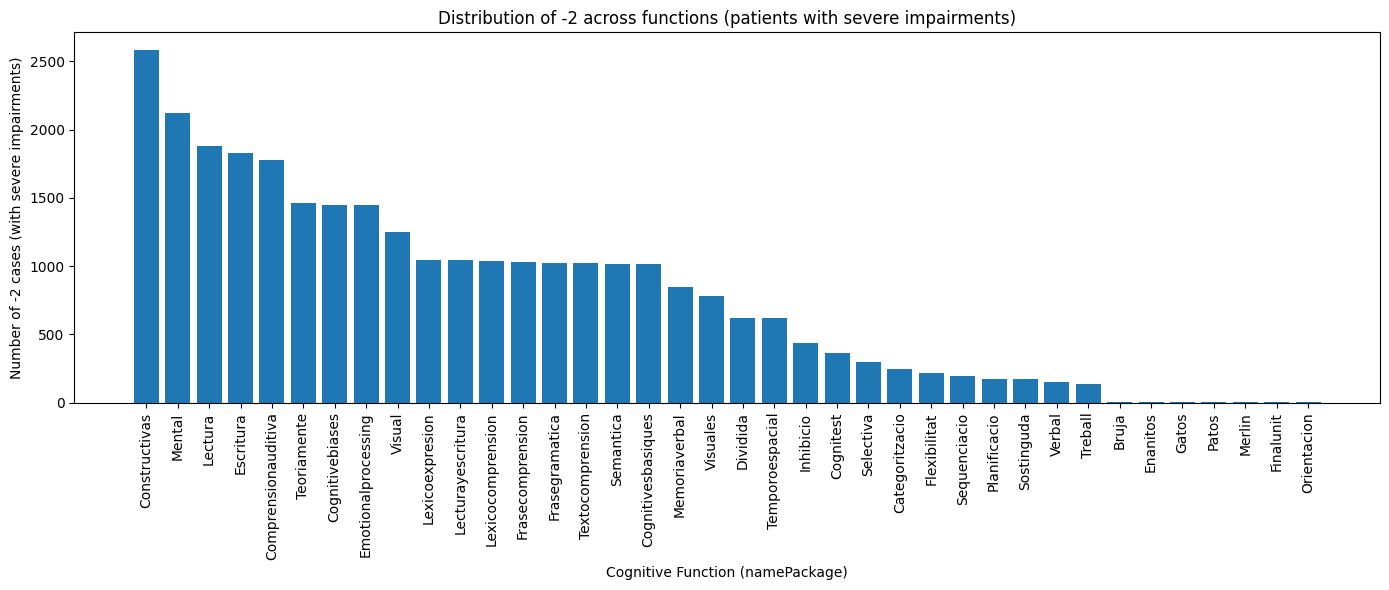

In [194]:
import matplotlib.pyplot as plt

# Step 1: Compute % of severe functions per treatment
total_functions = df.groupby("idTreatment")["idFunction"].nunique()
severe_counts = df[df["resultNormalized"] >= 3].groupby("idTreatment")["idFunction"].nunique()
severe_percentage = severe_counts / total_functions

# Step 2: Identify severe treatments (≥ 20% severe functions)
severe_ids = set(severe_percentage[severe_percentage >= 0.20].index)

# Step 3: Filter -2 cases from severe treatments
minus2_severe = df[(df["idTreatment"].isin(severe_ids)) & (df["resultNormalized"] == -2)]

# Step 4: Count -2 per cognitive function using namePackage
minus2_severe_counts = minus2_severe["namePackage"].value_counts().reset_index()
minus2_severe_counts.columns = ["namePackage", "count"]

# Step 5: Sort for visualization
minus2_severe_counts = minus2_severe_counts.sort_values(by="count", ascending=False)

# Step 6: Plot
plt.figure(figsize=(14, 6))
plt.bar(minus2_severe_counts["namePackage"], minus2_severe_counts["count"])
plt.xticks(rotation=90)
plt.xlabel("Cognitive Function (namePackage)")
plt.ylabel("Number of -2 cases (with severe impairments)")
plt.title("Distribution of -2 across functions (patients with severe impairments)")
plt.tight_layout()
plt.show()



In patients with severe impairments, non-evaluable scores (resultNormalized = -2) are frequently observed in certain cognitive functions such as Constructivas, Mental, and several language-related tasks like Lectura and Escritura.

In [195]:
import numpy as np

# Make sure the column is numeric
df['resultNormalized'] = pd.to_numeric(df['resultNormalized'], errors='coerce')

# Step 1: Exclude -2 values when calculating the percentage of severe functions
df_clean = df[df['resultNormalized'] != -2].copy()

# Step 2: Calculate the percentage of functions with score ≥ 3 for each idTreatment
severe_ratio = (
    df_clean.assign(severe=(df_clean['resultNormalized'] >= 3))
    .groupby('idTreatment')['severe']
    .mean()
)
severe_ids = severe_ratio[severe_ratio >= 0.3].index  # Treatments considered severe

# Step 3: Count total number of original -2 values
count_minus2_total = (df['resultNormalized'] == -2).sum()
percentage_minus2_total = (count_minus2_total / len(df)) * 100  # Moved here
original_values = df['resultNormalized'].copy()

# Step 4: Replace -2 values
def adjust_result(row):
    if row['resultNormalized'] == -2:
        if row['idTreatment'] in severe_ids:
            return 4  # Considered severely impaired, replace -2 with 4
        else:
            return np.nan  # Not severe, treat -2 as missing
    else:
        return row['resultNormalized']

df['resultNormalized'] = df.apply(adjust_result, axis=1)

# Step 5: Count replacements
count_minus2_to_4 = ((original_values == -2) & (df['resultNormalized'] == 4)).sum()
count_minus2_to_nan = ((original_values == -2) & (df['resultNormalized'].isna())).sum()

# Count of missing values
missing_count = df['resultNormalized'].isna().sum()

# Percentage of missing values
missing_percentage = (missing_count / len(df)) * 100

# Step 6: Print summary
print(f"Total original -2 values: {count_minus2_total}")
print(f"Percentage of -2 values over total: {percentage_minus2_total:.2f}%")
print(f"-2 values replaced with 4 (in severe cases): {count_minus2_to_4}")
print(f"-2 values replaced with NaN (in non-severe cases): {count_minus2_to_nan}")
print(f"Percentage missing: {missing_percentage:.2f}%")

# Convert to categorical
df["resultNormalized"] = df["resultNormalized"].astype("category")


Total original -2 values: 114597
Percentage of -2 values over total: 32.21%
-2 values replaced with 4 (in severe cases): 37123
-2 values replaced with NaN (in non-severe cases): 77474
Percentage missing: 21.77%


In [196]:
from scipy.stats import mode

# Group by idTreatment and macro domain on the original df
grouped = df.groupby(['idTreatment', 'macro_domain_corrected'])

# Impute directly on df
def impute_group_mode(group):
    non_missing = group['resultNormalized'].dropna()

    if len(non_missing) >= 1:
        result = mode(non_missing.to_numpy(), keepdims=False)
        mode_val = result.mode if hasattr(result, 'mode') else result[0]
        group['resultNormalized'] = group['resultNormalized'].fillna(mode_val)

    return group

# Apply in-place, overwrite df with the updated version
df = grouped.apply(impute_group_mode).reset_index(drop=True)

/tmp/ipython-input-196-1566546305.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = grouped.apply(impute_group_mode).reset_index(drop=True)


In [197]:
# Count of missing values
missing_count = df['resultNormalized'].isna().sum()

# Percentage of missing values
missing_percentage = (missing_count / len(df)) * 100

# Print summary
print(f"Missing values in 'resultNormalized': {missing_count}")
print(f"Percentage missing: {missing_percentage:.2f}%")


Missing values in 'resultNormalized': 63735
Percentage missing: 17.91%


Based on this, a two-step strategy was applied. First, all -2 values in severe
treatments were recoded as 4 ( high cognitive impairment), while in all other cases
they were treated as missing. Subsequently, for each treatment and cognitive macro-
domain, if at least one subfunction had a valid score, missing values in other sub-
functions within the same domain were imputed using the mode of the available
scores. This ensured that imputations remained consistent with the patient’s clinical
profile. The strategy was reviewed and validated by a clinical expert.

### AGE

In [198]:
# Descriptive statistics for age at first test
print("\nDescriptive statistics for 'age_at_first_test':")
print(df["age_at_first_test"].describe())


Descriptive statistics for 'age_at_first_test':
count    355802.000000
mean         50.139457
std          20.246242
min         -50.000000
25%          37.000000
50%          52.000000
75%          65.000000
max         101.000000
Name: age_at_first_test, dtype: float64


In [199]:
# Count of negative values
negative_ages = (df["age_at_first_test"] < 0).sum()
print(f"Number of negative ages: {negative_ages}")

# Count of zeros or less (incluso 0)
non_positive_ages = (df["age_at_first_test"] <= 0).sum()
print(f"Number of non-positive ages (<= 0): {non_positive_ages}")

# Percentage
total = len(df)
perc = non_positive_ages / total * 100
print(f"Percentage of non-positive ages: {perc:.2f}%")


Number of negative ages: 37
Number of non-positive ages (<= 0): 1064
Percentage of non-positive ages: 0.30%


In [200]:
df = df[df["age_at_first_test"] > 0]
print(df["age_at_first_test"].describe())

count    354738.000000
mean         50.292489
std          20.079436
min           1.000000
25%          37.000000
50%          52.000000
75%          65.000000
max         101.000000
Name: age_at_first_test, dtype: float64


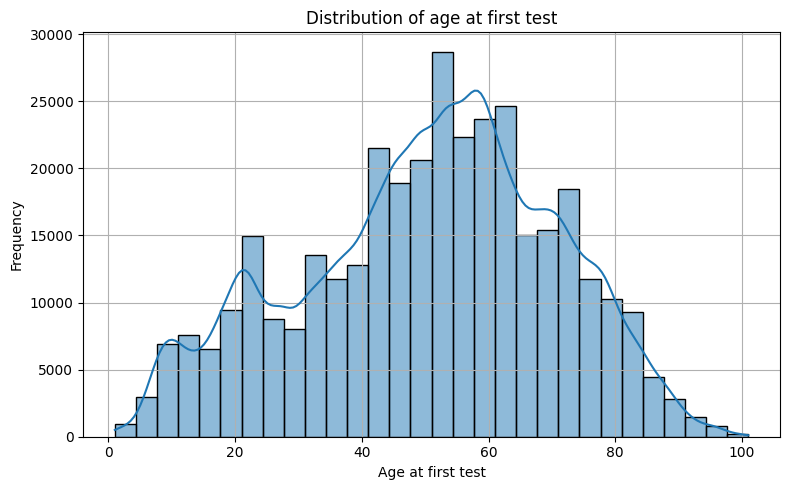

In [201]:
plt.figure(figsize=(8, 5))
sns.histplot(df["age_at_first_test"], kde=True, bins=30)
plt.title("Distribution of age at first test")
plt.xlabel("Age at first test")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


###FUNCTIONS

In [202]:
# 1. Average number of functions per treatment
functions_per_treatment = df.groupby("idTreatment")["idFunction"].nunique()
print("Average number of functions per treatment:", functions_per_treatment.mean())

# 2. Check for duplicates (idTreatment + idFunction)
duplicates = df.duplicated(subset=["idTreatment", "idFunction"], keep=False)
n_duplicates = duplicates.sum()
print("Number of duplicate idTreatment + idFunction combinations:", n_duplicates)

Average number of functions per treatment: 18.70487740574743
Number of duplicate idTreatment + idFunction combinations: 0


In [203]:
functions_per_treatment = df.groupby("idTreatment")["idFunction"].nunique()
print(functions_per_treatment.describe())

count    18965.000000
mean        18.704877
std          5.590077
min          1.000000
25%         17.000000
50%         18.000000
75%         21.000000
max         33.000000
Name: idFunction, dtype: float64


On average, each treatment includes about 19 different cognitive functions. The number of functions per treatment varies between 1 and 33, with most treatments covering between 17 and 21 functions (50% of cases have 18 functions).

In [204]:
df["idFunction"] = df["idFunction"].astype("category")
df["idFunction"] = df["idFunction"].cat.remove_unused_categories()
used_functions = df["idFunction"].cat.categories.tolist()
print("ID of functions used in the dataset:")
print(used_functions)
print(f"Number of functions used: {len(used_functions)}")

ID of functions used in the dataset:
[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 44, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 60, 61, 62, 63, 64, 66, 67, 68, 70, 71, 72, 73, 74, 75, 83, 85, 87, 89, 91, 93, 95, 96, 98, 100, 101, 102, 104, 106, 107, 108, 109, 110, 112, 113, 114, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 130, 131, 132, 149, 151, 152, 154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 170, 172, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 211, 212, 213, 214, 215, 219, 221, 223, 225, 227, 228, 229, 230, 232, 233, 234, 236, 237, 238, 239, 240, 241, 243, 244, 245, 246, 248, 250, 251, 252, 254, 256, 258, 262, 263, 264, 266, 267, 268, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 299]
Number of functions used: 187


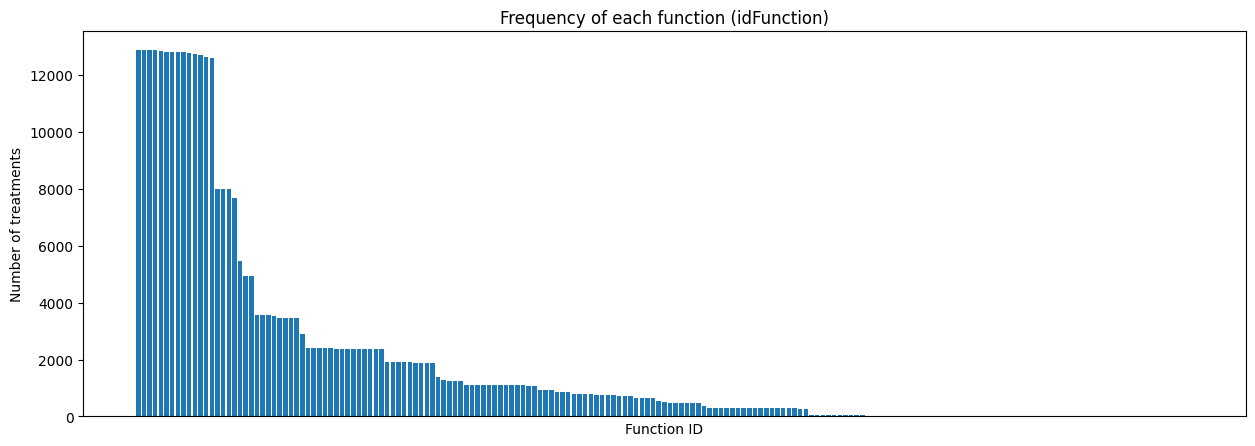

In [205]:
functions_frequency = df["idFunction"].value_counts()
plt.figure(figsize=(15, 5))
plt.bar(functions_frequency.index.astype(str), functions_frequency.values)
plt.xlabel("Function ID")
plt.ylabel("Number of treatments")
plt.title("Frequency of each function (idFunction)")
plt.xticks([], [])
plt.show()

The plot shows that a few functions are used very often, while most functions are rarely used.  

Since only a few functions are frequently used, selecting them based on their data coverage will help improve clustering robustness and reduce noise from rarely used variables.

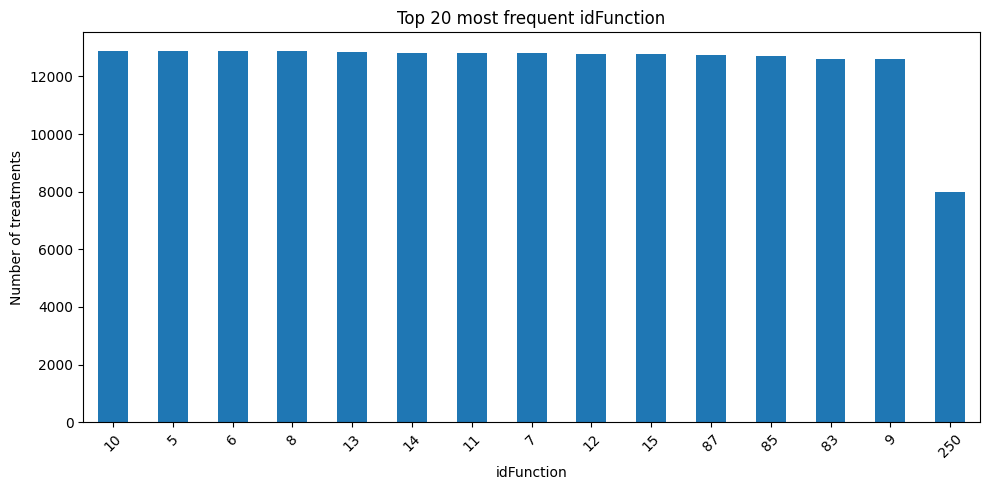

     idFunction          namePackage
2             5           Sostinguda
0             6            Selectiva
1             7             Dividida
13            8               Verbal
14            9               Visual
15           10              Treball
4            11         Planificacio
5            12            Inhibicio
6            13         Flexibilitat
7            14         Sequenciacio
8            15       Categoritzacio
11           19              Lectura
12           20  Comprensionauditiva
3            83               Mental
9            85             Visuales
16           87      Temporoespacial
17           89        Constructivas
2313        250      Cognitivebiases
2312        251  Emotionalprocessing
2311        252          Teoriamente


In [206]:
top_functions = functions_frequency.head(15)

plt.figure(figsize=(10, 5))
top_functions.plot(kind="bar")
plt.title("Top 20 most frequent idFunction")
plt.xlabel("idFunction")
plt.ylabel("Number of treatments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

top_functions = functions_frequency.head(20).index.tolist()

top_domains = df[df["idFunction"].isin(top_functions)][["idFunction", "namePackage"]].drop_duplicates()

top_domains = top_domains.sort_values("idFunction")

print(top_domains)


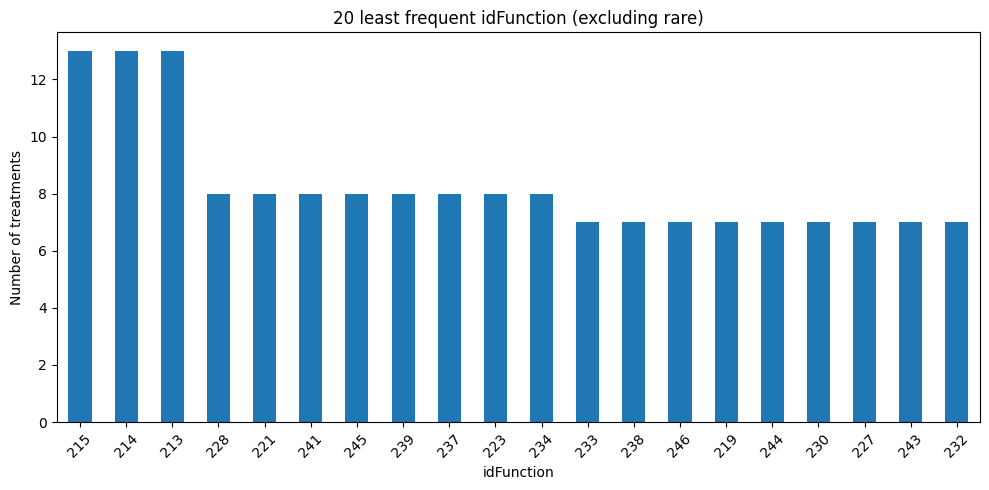

      idFunction          namePackage
98955        213                Gatos
98958        214               Merlin
98959        215                Patos
77497        219  Emotionalprocessing
77490        221       Categoritzacio
77492        223               Visual
77484        227            Selectiva
77494        228               Verbal
77483        230           Sostinguda
77485        232               Mental
77499        233      Cognitivebiases
77487        234         Flexibilitat
77493        237              Treball
77496        238          Teoriamente
77486        239         Sequenciacio
77489        241         Planificacio
77495        243      Temporoespacial
77482        244             Dividida
77488        245            Inhibicio
77498        246            Finalunit


In [207]:
bottom_functions = functions_frequency[functions_frequency > 5].tail(20)

plt.figure(figsize=(10, 5))
bottom_functions.plot(kind="bar")
plt.title("20 least frequent idFunction (excluding rare)")
plt.xlabel("idFunction")
plt.ylabel("Number of treatments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

bottom_domains = df[df["idFunction"].isin(bottom_functions.index)][["idFunction", "namePackage"]].drop_duplicates()
bottom_domains = bottom_domains.sort_values("idFunction")

print(bottom_domains)


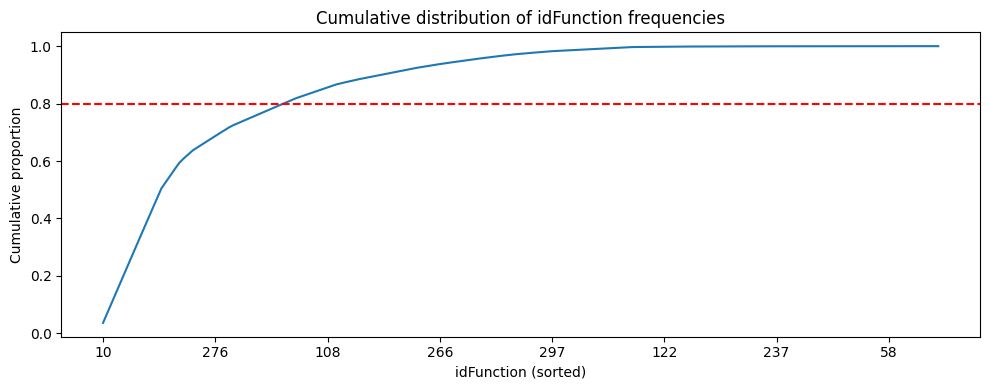

In [208]:
cumulative = functions_frequency.cumsum() / functions_frequency.sum()
plt.figure(figsize=(10, 4))
cumulative.plot()
plt.axhline(0.80, color='red', linestyle='--')
plt.title("Cumulative distribution of idFunction frequencies")
plt.xlabel("idFunction (sorted)")
plt.ylabel("Cumulative proportion")
plt.tight_layout()
plt.show()

The plot shows the cumulative distribution of idfunction frequencies. A small subset of functions (approximately 20–25%) accounts for more than 80% of the total occurrences, indicating a strong imbalance. This insight will be used to retain only the most frequent functions when reshaping the dataset for clustering.


In [209]:
functions_cumsum = functions_frequency.cumsum() / functions_frequency.sum()
top_functions = functions_cumsum[functions_cumsum <= 0.80]

# Merge to get the cognitive domain names for the top functions
top_functions_df = pd.DataFrame({"idFunction": top_functions.index.tolist()})
top_functions_df = top_functions_df.merge(
    function_package[["idFunction", "namePackage"]],
    on="idFunction",
    how="left"
)

print(f"Number of functions that cover 80% of the data: {len(top_functions_df)}")
print("Function IDs and their cognitive domains:")


print(top_functions_df)

Number of functions that cover 80% of the data: 41
Function IDs and their cognitive domains:
    idFunction          namePackage
0           10              Treball
1            5           Sostinguda
2            6            Selectiva
3            8               Verbal
4           13         Flexibilitat
5           14         Sequenciacio
6           11         Planificacio
7            7             Dividida
8           12            Inhibicio
9           15       Categoritzacio
10          87      Temporoespacial
11          85             Visuales
12          83               Mental
13           9               Visual
14         250      Cognitivebiases
15         252          Teoriamente
16         251  Emotionalprocessing
17          89        Constructivas
18          20  Comprensionauditiva
19          19              Lectura
20          18            Escritura
21         274      Lexicoexpresion
22         275    Lexicocomprension
23         272    Lecturayescritura
24     

### GENDER

          Count  Percentage (%)
is_male                        
1.0      203294           57.31
0.0      151444           42.69


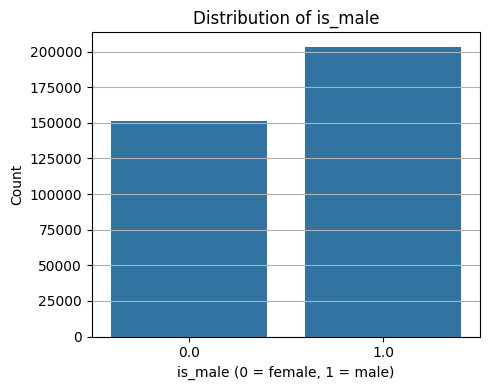

In [210]:
counts = df["is_male"].value_counts(dropna=False)
percentages = df["is_male"].value_counts(normalize=True, dropna=False) * 100
summary = pd.DataFrame({"Count": counts, "Percentage (%)": percentages.round(2)})
print(summary)

plt.figure(figsize=(5, 4))
sns.countplot(data=df, x="is_male", order=sorted(df["is_male"].dropna().unique()))
plt.title("Distribution of is_male")
plt.xlabel("is_male (0 = female, 1 = male)")
plt.ylabel("Count")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

### STUDIES

In [211]:
counts = df["studies"].value_counts(dropna=False).sort_index()
percentages = df["studies"].value_counts(normalize=True, dropna=False).sort_index() * 100
summary = pd.DataFrame({"Count": counts, "Percentage (%)": percentages.round(2)})
print(summary)

          Count  Percentage (%)
studies                        
0.0       14667            4.13
1.0      160264           45.18
2.0      102535           28.90
3.0       77272           21.78


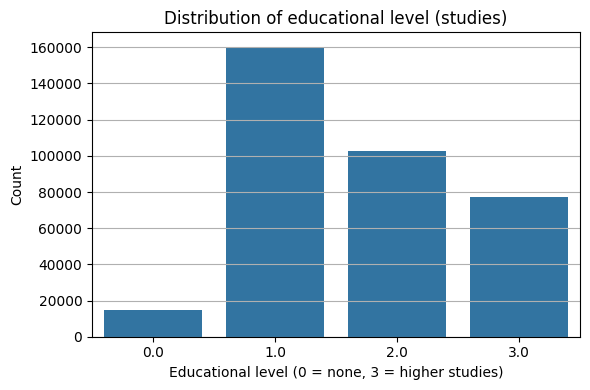

In [212]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="studies", order=sorted(df["studies"].dropna().unique()))
plt.title("Distribution of educational level (studies)")
plt.xlabel("Educational level (0 = none, 3 = higher studies)")
plt.ylabel("Count")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

ETHIOLOGY

           Count  Percentage (%)
ethiology                       
-1.0       53944           15.21
 0.0       14560            4.10
 1.0       81628           23.01
 2.0        8401            2.37
 3.0       28324            7.98
 4.0       10413            2.94
 5.0       11373            3.21
 6.0        4746            1.34
 7.0       46631           13.15
 8.0        1029            0.29
 9.0         893            0.25
 10.0       2082            0.59
 11.0       4547            1.28
 12.0       3277            0.92
 13.0       3854            1.09
 14.0      30071            8.48
 15.0      14132            3.98
 16.0       2285            0.64
 17.0       1567            0.44
 18.0       1847            0.52
 19.0       2851            0.80
 20.0       7175            2.02
 21.0       3523            0.99
 22.0       4957            1.40
 23.0       6029            1.70
 25.0        299            0.08
 26.0       1164            0.33
 27.0        795            0.22
 28.0     

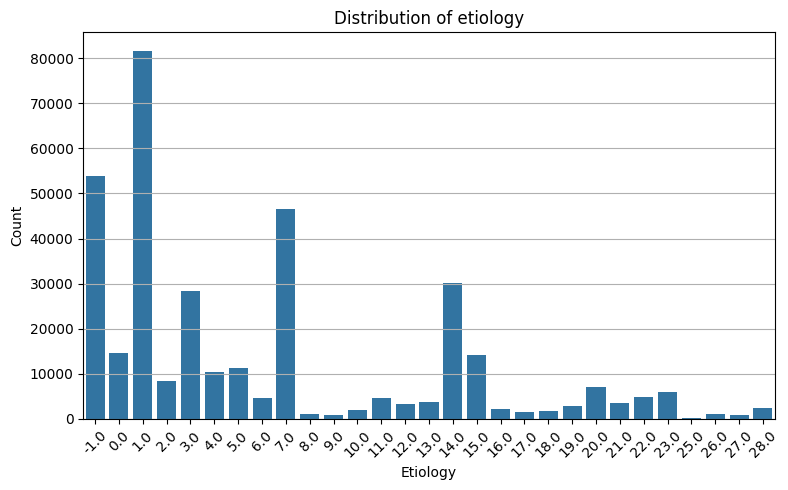

In [213]:
counts = df["ethiology"].value_counts(dropna=False).sort_index()
percentages = df["ethiology"].value_counts(normalize=True, dropna=False).sort_index() * 100
summary = pd.DataFrame({"Count": counts, "Percentage (%)": percentages.round(2)})
print(summary)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="ethiology", order=sorted(df["ethiology"].dropna().unique()))
plt.title("Distribution of etiology")
plt.xlabel("Etiology")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

                         Count  Percentage (%)
etiology_grouped                              
Neurodegenerative        65020           18.33
Neurodevelopmental       22963            6.47
Other                    62220           17.54
Psychiatric              14998            4.23
Traumatic/Neurosurgical  41712           11.76
Undefined                53944           15.21
Vascular/Anoxic          93881           26.46


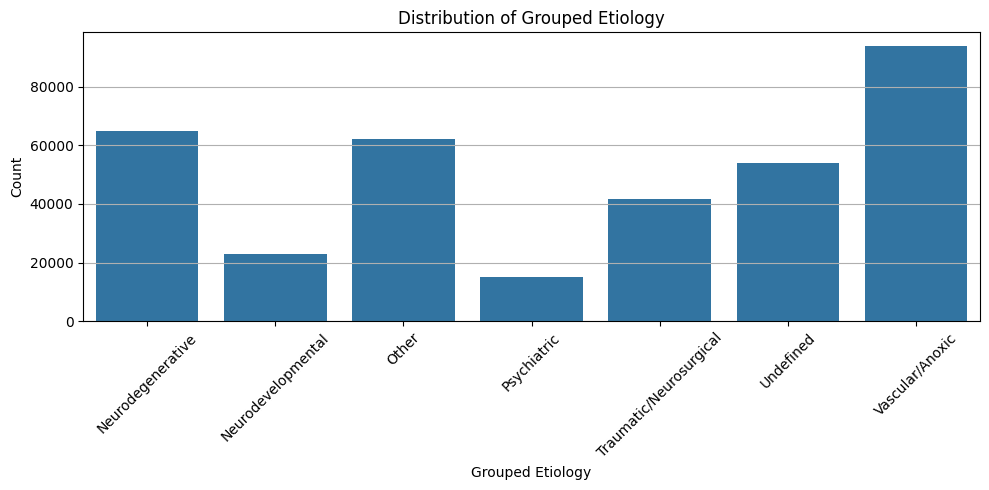

In [214]:
etiology_map = {
    -1: 'Undefined', 0: 'Other', 1: 'Vascular/Anoxic', 2: 'Vascular/Anoxic',
    3: 'Traumatic/Neurosurgical', 4: 'Traumatic/Neurosurgical',
    5: 'Neurodegenerative', 6: 'Neurodegenerative', 7: 'Other', 8: 'Other',
    9: 'Traumatic/Neurosurgical', 10: 'Traumatic/Neurosurgical',
    11: 'Neurodevelopmental', 12: 'Neurodevelopmental', 13: 'Neurodevelopmental',
    14: 'Neurodegenerative', 15: 'Neurodegenerative', 16: 'Vascular/Anoxic',
    17: 'Vascular/Anoxic', 18: 'Neurodegenerative', 19: 'Neurodegenerative',
    20: 'Psychiatric', 21: 'Psychiatric', 22: 'Neurodevelopmental', 23: 'Neurodevelopmental',
    25: 'Neurodevelopmental', 26: 'Psychiatric', 27: 'Psychiatric', 28: 'Psychiatric'
}
df["etiology_grouped"] = df["ethiology"].map(etiology_map)
summary = df["etiology_grouped"].value_counts(normalize=False).sort_index().to_frame(name="Count")
summary["Percentage (%)"] = df["etiology_grouped"].value_counts(normalize=True).sort_index() * 100
summary["Percentage (%)"] = summary["Percentage (%)"].round(2)
print(summary)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="etiology_grouped", order=sorted(df["etiology_grouped"].dropna().unique()))
plt.title("Distribution of Grouped Etiology")
plt.xlabel("Grouped Etiology")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


### ORIGIN_TYPE


In [215]:
counts = df["origin_type"].value_counts(dropna=False)
percentages = df["origin_type"].value_counts(normalize=True, dropna=False) * 100
summary = pd.DataFrame({"Count": counts, "Percentage (%)": percentages.round(2)})
print(summary)

              Count  Percentage (%)
origin_type                        
equalizer    235207            66.3
test         119531            33.7


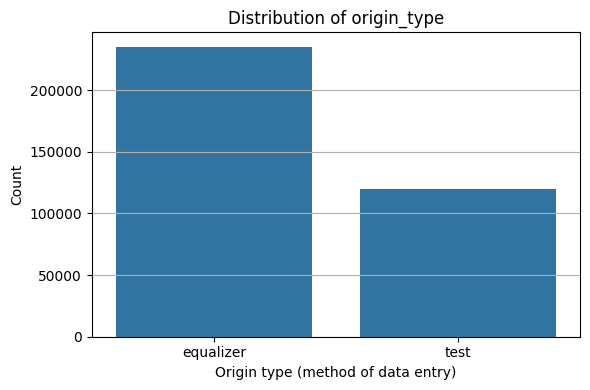

In [216]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="origin_type", order=df["origin_type"].value_counts().index)
plt.title("Distribution of origin_type")
plt.xlabel("Origin type (method of data entry)")
plt.ylabel("Count")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

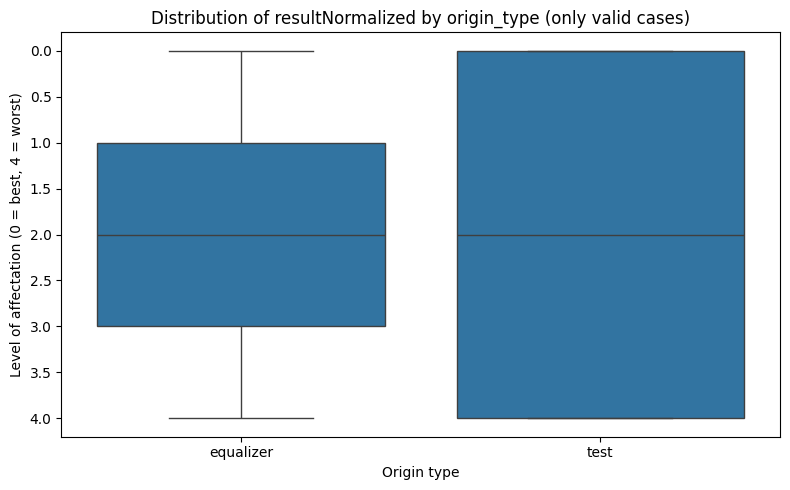

In [217]:
df_valid = df[df["resultNormalized"].astype(float) >= 0]

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_valid, x="origin_type", y="resultNormalized")
plt.title("Distribution of resultNormalized by origin_type (only valid cases)")
plt.xlabel("Origin type")
plt.ylabel("Level of affectation (0 = best, 4 = worst)")
plt.tight_layout()
plt.show()

In [218]:
pd.set_option("display.max_columns", None)
print(pd.crosstab(df["origin_type"], df["resultNormalized"], margins=True))

resultNormalized    0.0    1.0    2.0    3.0    4.0     All
origin_type                                                
equalizer         39788  49362  49906  27339  38468  204863
test              25064  14006  11331   7166  28921   86488
All               64852  63368  61237  34505  67389  291351


There are clear differences in resultNormalized between the two origin types. Patients in the "equalizer" group show a wider range of severity, with a median level of 2. In the "test" group, most patients are at milder levels, with a median closer to 1.

The percentage of non-evaluable patients (resultNormalized = -2) is also much higher in the "test" group (48.4%) than in the "equalizer" group (23.9%). This suggests that the way the data was collected may affect both how complete the results are and how severity is shown.


### PROFILE

In [219]:
counts = df["profile"].value_counts(dropna=False).sort_index()
percentages = df["profile"].value_counts(normalize=True, dropna=False).sort_index() * 100
summary = pd.DataFrame({"Count": counts, "Percentage (%)": percentages.round(2)})
print(summary)


          Count  Percentage (%)
profile                        
 0.0      89318           25.18
 1.0      24352            6.86
 2.0     142534           40.18
 3.0      20426            5.76
 4.0      17036            4.80
 5.0       7335            2.07
 6.0      10079            2.84
 7.0      16532            4.66
 8.0      18389            5.18
NaN        8737            2.46


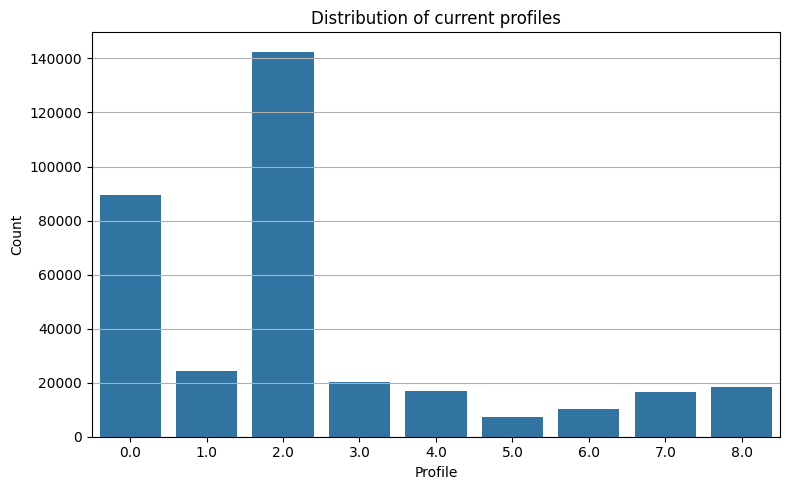

In [220]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="profile", order=sorted(df["profile"].dropna().unique()))
plt.title("Distribution of current profiles")
plt.xlabel("Profile")
plt.ylabel("Count")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()


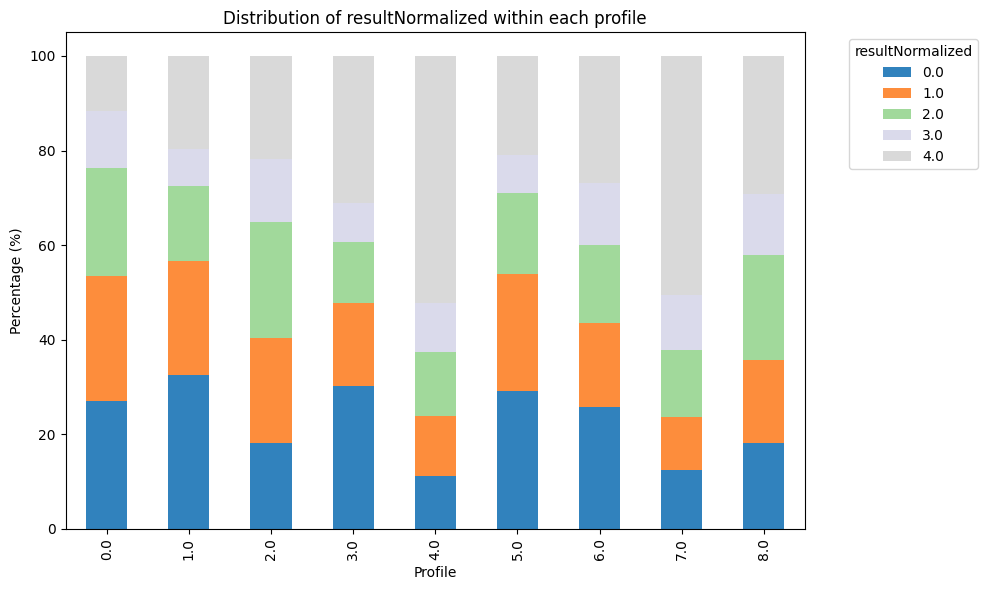

In [221]:
cross_tab_pct = pd.crosstab(df["profile"], df["resultNormalized"], normalize="index") * 100

# Plot
cross_tab_pct.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="tab20c")
plt.title("Distribution of resultNormalized within each profile")
plt.xlabel("Profile")
plt.ylabel("Percentage (%)")
plt.legend(title="resultNormalized", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


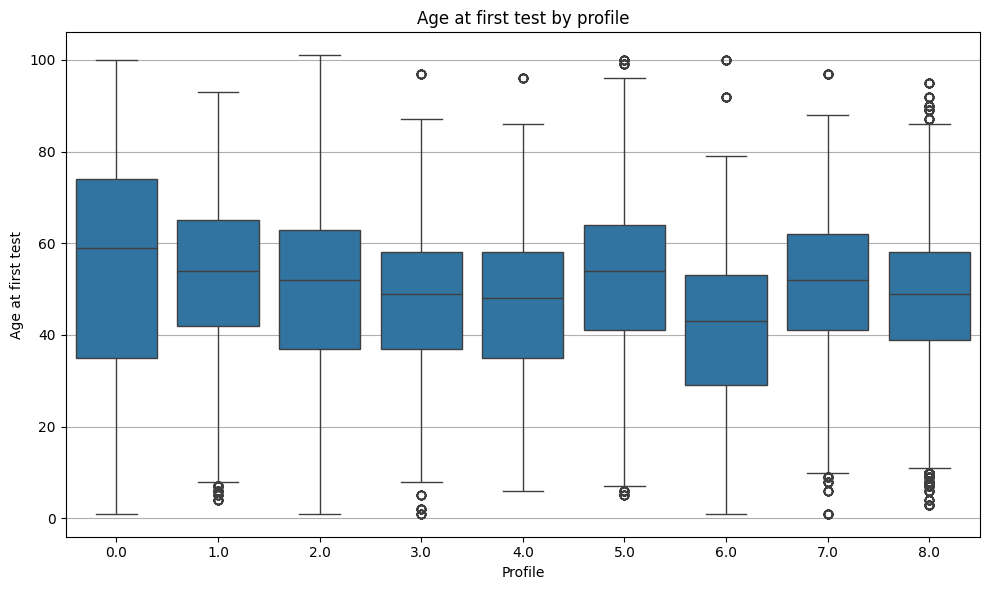

In [222]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="profile", y="age_at_first_test")
plt.title("Age at first test by profile")
plt.xlabel("Profile")
plt.ylabel("Age at first test")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()


Some profiles include both younger and older patients, while others show a more concentrated age range. Profile 0 has the widest age distribution, including many older patients, while profiles like 6 show generally younger ages. These differences suggest that age may be an important factor in the definition of profiles.

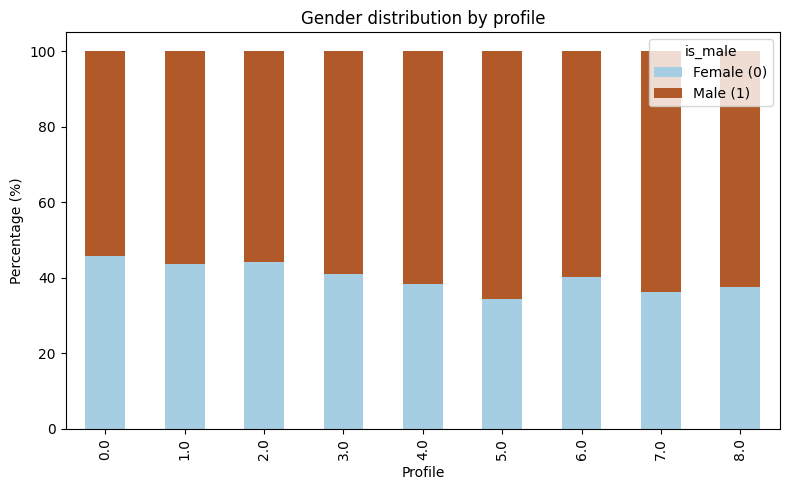

In [223]:
gender_pct = pd.crosstab(df["profile"], df["is_male"], normalize="index") * 100
gender_pct.plot(kind="bar", stacked=True, figsize=(8, 5), colormap="Paired")
plt.title("Gender distribution by profile")
plt.xlabel("Profile")
plt.ylabel("Percentage (%)")
plt.legend(title="is_male", labels=["Female (0)", "Male (1)"])
plt.tight_layout()
plt.show()


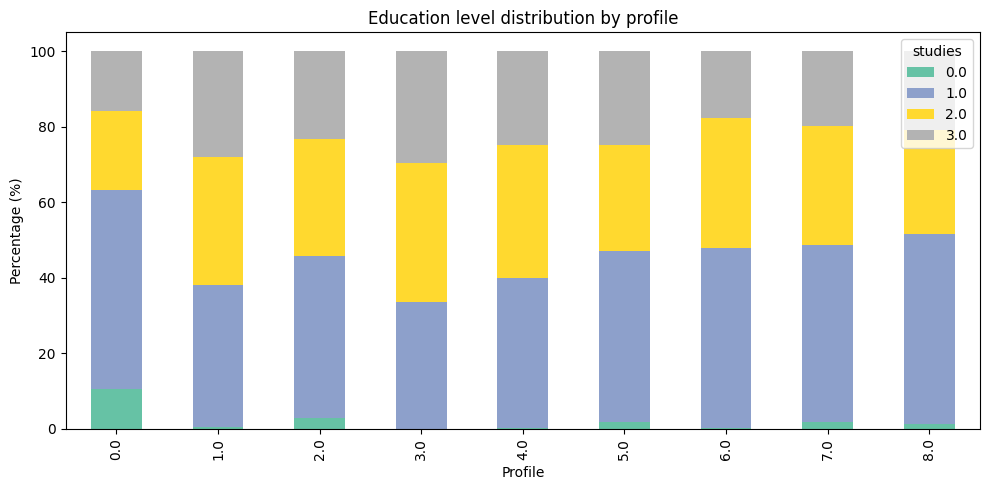

In [224]:
studies_pct = pd.crosstab(df["profile"], df["studies"], normalize="index") * 100
studies_pct.plot(kind="bar", stacked=True, figsize=(10, 5), colormap="Set2")
plt.title("Education level distribution by profile")
plt.xlabel("Profile")
plt.ylabel("Percentage (%)")
plt.legend(title="studies", loc="upper right")
plt.tight_layout()
plt.show()


Profile 0 has the highest proportion of patients with no education (level 0) and primary education (level 1), while higher education levels (2 and 3) are more frequent in the other profiles. This suggests that patients in profile 0 tend to have a lower educational background compared to the other groups. Overall, profiles 1 to 8 show a more balanced mix of education levels, with many patients having secondary (2) or higher education (3).

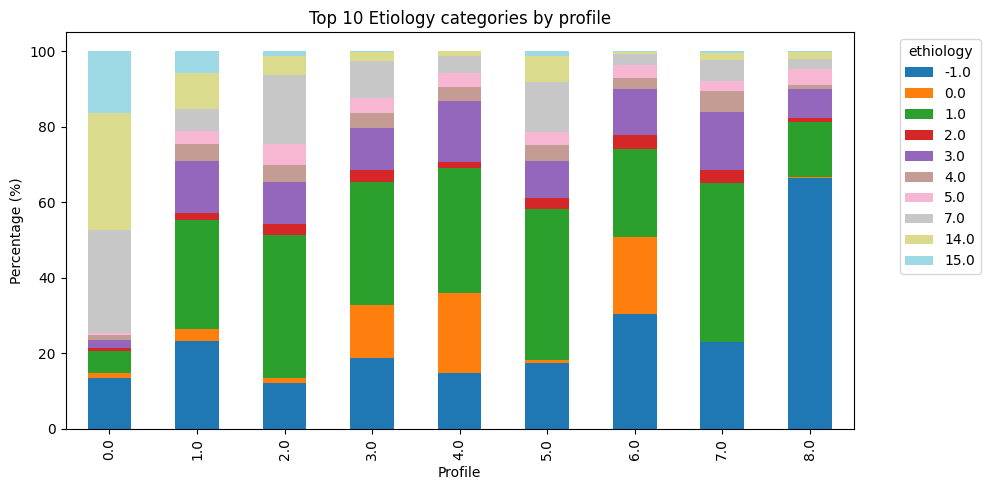

In [225]:
top_ethiologies = df["ethiology"].value_counts().head(10).index
df_filtered = df[df["ethiology"].isin(top_ethiologies)]
pd.crosstab(df_filtered["profile"], df_filtered["ethiology"], margins=True)

ethio_pct = pd.crosstab(df_filtered["profile"], df_filtered["ethiology"], normalize="index") * 100
ethio_pct.plot(kind="bar", stacked=True, figsize=(10, 5), colormap="tab20")
plt.title("Top 10 Etiology categories by profile")
plt.xlabel("Profile")
plt.ylabel("Percentage (%)")
plt.legend(title="ethiology", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The distribution of etiology categories is very different across profiles. Profile 8 shows the highest percentage of patients with undefined or unspecified etiology (-1.0). Other profiles, like 2, 4, and 5, are mainly composed of patients with etiology code 1.0. Some categories, such as 3.0, 7.0, or 14.0, also vary across profiles. This suggests that etiology may play an important role in the definition of these profiles.

## KMODES K=5

In [226]:
# 1. Pivot the dataframe: one row per treatment, one column per function
df_pivot_50 = df.pivot(index='idTreatment', columns='idFunction', values='resultNormalized').reset_index()

# 2. Calculate sparsity (percentage of NaN) for each function (column-wise)
sparsity_per_function_50 = df_pivot_50.drop('idTreatment', axis=1).isna().mean() * 100

# 3. Keep only functions with ≤50% missing values
threshold_50 = 50
functions_to_keep_50 = sparsity_per_function_50[sparsity_per_function_50 <= threshold_50].index.tolist()
df_pivot_filtered_50 = df_pivot_50[['idTreatment'] + functions_to_keep_50]

# 4. Calculate sparsity for each treatment (row-wise) and filter those with ≤50% missing values
sparsity_per_patient_50 = df_pivot_filtered_50.drop('idTreatment', axis=1).isna().mean(axis=1) * 100

# Make a copy before modifying
df_pivot_filtered_50 = df_pivot_filtered_50.copy()
df_pivot_filtered_50['sparsity_percentage'] = sparsity_per_patient_50

# Apply final filter
df_pivot_filtered_50 = df_pivot_filtered_50[df_pivot_filtered_50['sparsity_percentage'] <= 50]
df_pivot_filtered_50 = df_pivot_filtered_50.drop('sparsity_percentage', axis=1)

rowwise_nan_pct = df_pivot_filtered_50.drop('idTreatment', axis=1).isna().mean(axis=1) * 100
mean_nan_pct = rowwise_nan_pct.mean()
print(f"Mean missing percentage per treatment: {mean_nan_pct:.2f}%")

Mean missing percentage per treatment: 4.16%


In [227]:
df_pivot_filtered_50 = df_pivot_filtered_50.dropna()

In [228]:
# Step 5: Load function metadata and identify retained functions
functions_metadata = df[['idFunction', 'namePackage', 'macro_domain_corrected']].drop_duplicates()

# Step 6: Filter metadata to keep only retained functions
functions_metadata_filtered_50 = functions_metadata[functions_metadata['idFunction'].isin(functions_to_keep_50)]

# Step 7: Sort by macro domain for better readability
functions_metadata_filtered_50 = functions_metadata_filtered_50.sort_values(by='macro_domain_corrected')

# Step 8: Display the retained functions
print("Functions retained after applying the 50% sparsity filter:")
display(functions_metadata_filtered_50.reset_index(drop=True))

Functions retained after applying the 50% sparsity filter:


,idFunction,namePackage,macro_domain_corrected
0,6,Selectiva,Atencio
1,7,Dividida,Atencio
2,5,Sostinguda,Atencio
3,83,Mental,Calculo
4,11,Planificacio,Funcionsexecutives
5,12,Inhibicio,Funcionsexecutives
6,13,Flexibilitat,Funcionsexecutives
7,14,Sequenciacio,Funcionsexecutives
8,15,Categoritzacio,Funcionsexecutives
9,85,Visuales,Gnosias


/tmp/ipython-input-229-3482959563.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_data = df_filtered.groupby(['function_name', 'resultNormalized']).size().reset_index(name='count')


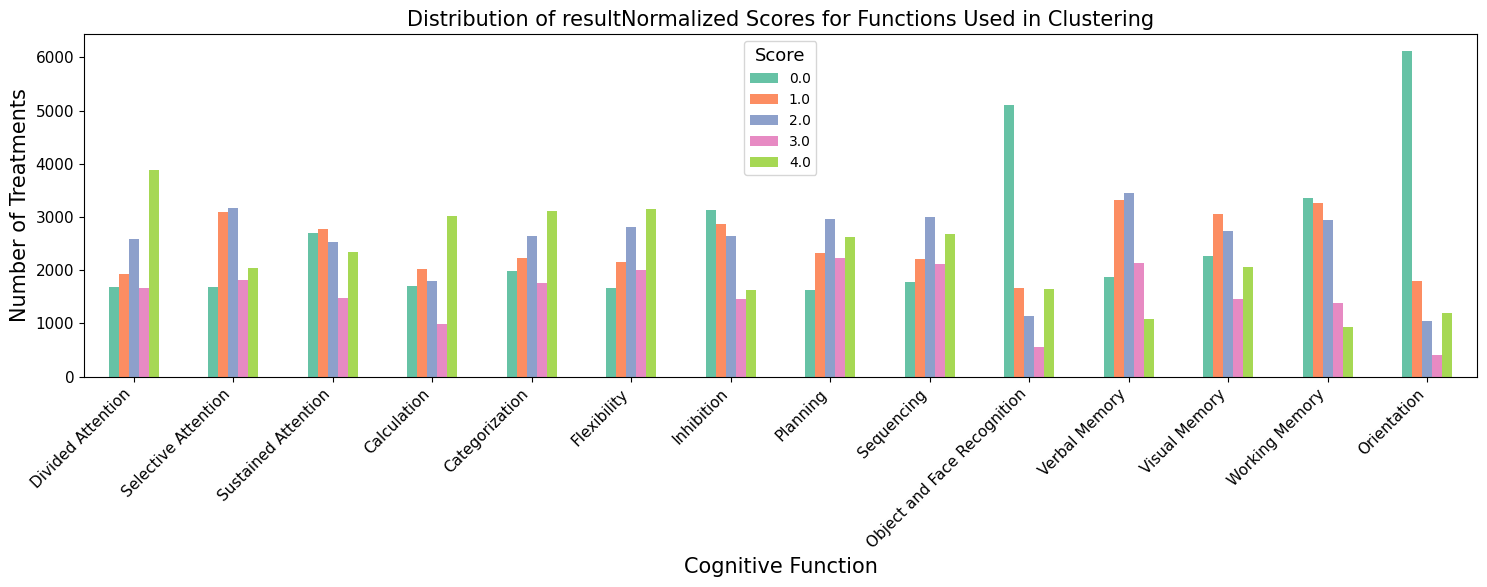

In [229]:
import pandas as pd
import matplotlib.pyplot as plt

# Updated mapping from idFunction to readable names (in English)
function_labels = {
    5: 'Sustained Attention',
    6: 'Selective Attention',
    7: 'Divided Attention',
    8: 'Verbal Memory',
    9: 'Visual Memory',
    10: 'Working Memory',
    11: 'Planning',
    12: 'Inhibition',
    13: 'Flexibility',
    14: 'Sequencing',
    15: 'Categorization',
    83: 'Calculation',
    85: 'Object and Face Recognition',
    87: 'Orientation'
}

# Updated mapping from idFunction to macro domain (in English)
function_domains = {
    5: 'Attention',
    6: 'Attention',
    7: 'Attention',
    8: 'Memory',
    9: 'Memory',
    10: 'Memory',
    11: 'Executive Functions',
    12: 'Executive Functions',
    13: 'Executive Functions',
    14: 'Executive Functions',
    15: 'Executive Functions',
    83: 'Calculation',
    85: 'Gnosias',
    87: 'Orientation'
}


import pandas as pd
import matplotlib.pyplot as plt

# [mappings as above]

# Filter the original dataframe
df_filtered = df[df['idFunction'].isin(function_labels.keys())].copy()
df_filtered['function_name'] = df_filtered['idFunction'].map(function_labels)
df_filtered['macro_domain'] = df_filtered['idFunction'].map(function_domains)

# Count occurrences
count_data = df_filtered.groupby(['function_name', 'resultNormalized']).size().reset_index(name='count')

# Sort functions for visualization
function_order = pd.DataFrame.from_dict(function_domains, orient='index', columns=['domain'])
function_order['function_name'] = function_order.index.map(function_labels)
function_order = function_order.sort_values(by=['domain', 'function_name'])
ordered_names = function_order['function_name'].tolist()

# Pivot for plotting
count_pivot = count_data.pivot(index='function_name', columns='resultNormalized', values='count').fillna(0)
count_pivot = count_pivot.loc[ordered_names]

plt.rcParams.update({'font.size': 11})


# Plot
color_palette = plt.get_cmap('Set2')

ax = count_pivot.plot(
    kind='bar',
    stacked=False,
    figsize=(15, 6),
    color=[color_palette(i) for i in range(count_pivot.shape[1])]
)

plt.title('Distribution of resultNormalized Scores for Functions Used in Clustering', fontsize=15)
plt.xlabel('Cognitive Function', fontsize=15)
plt.ylabel('Number of Treatments', fontsize=15)
plt.legend(title='Score', fontsize=10, title_fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()





In [230]:
# 5. Merge the stricter filtered dataset with demographic variables
# 5. Compute the mode for each demographic variable grouped by idTreatment
demographic_cols = ['idTreatment', 'age_at_first_test', 'is_male', 'studies', 'ethiology']

demographics = (
    df[demographic_cols]
    .groupby('idTreatment')
    .agg(lambda x: x.mode().iloc[0])  # Prende la moda per ciascuna colonna
    .reset_index()
)
df_merged_50 = df_pivot_filtered_50.merge(demographics, on='idTreatment', how='left')

# Step 6 (updated): Categorize patient age based on quantiles
# Compute quantile-based bins
filtered_ages = df[df['idTreatment'].isin(df_pivot_filtered_50['idTreatment'])]['age_at_first_test']

# Define custom labels for the bins
age_labels = ['<35', '35-45', '45-55', '55-65', '65+']

# Define new age bins based on quantile cutoffs
age_bins = [0, 35, 45, 55, 65, 120]
age_labels = ['<35', '35-45', '45-55', '55-65', '65+']

df_merged_50['age_category'] = pd.cut(
    df_merged_50['age_at_first_test'],
    bins=age_bins,
    labels=age_labels,
    right=False
)

df_merged_50 = df_merged_50.drop('age_at_first_test', axis=1)

# 7. Create grouped etiology variable

etiology_map = {
    -1: None, 0: None, 7: None, # Exclude undefined

    1: 'Vascular',
    2: 'Anoxic',
    3: 'Traumatic/Neurosurgical',
    4: 'Other',      # Tumor
    5: 'Neurodegenerative', 6: 'Neurodegenerative', 14: 'Neurodegenerative',
    15: 'Neurodegenerative', 16: 'Neurodegenerative', 17: 'Neurodegenerative',
    18: 'Neurodegenerative', 19: 'Neurodegenerative',
    9: 'Traumatic/Neurosurgical',  8: 'Other',
    10: 'Other',     # Paralisis
    11: 'Other',     # Neurodevelopmental
    13: 'Other',     # Neurodevelopmental
    22: 'Other',     # Neurodevelopmental
    23: 'Other',
    25: 'Other',
    12: 'Other',     # Epilepsia
    20: 'Psychiatric', 21: 'Psychiatric', 26: 'Psychiatric',
    27: 'Psychiatric', 28: 'Psychiatric'
}


# df_merged_50['etiology_grouped'] = df_merged_50['ethiology'].map(etiology_map)
df_merged_50['etiology_grouped'] = df_merged_50['ethiology'].map(etiology_map)
df_merged_50 = df_merged_50[df_merged_50['etiology_grouped'].notna()]


/tmp/ipython-input-231-3385512483.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_merged_50['studies_grouped'] = df_merged_50['studies'].replace({0: 1})
/tmp/ipython-input-231-3385512483.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/tmp/ipython-input-231-3385512483.py:19: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.countplot(
/tmp/ipython-input-231-3385512483.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.co

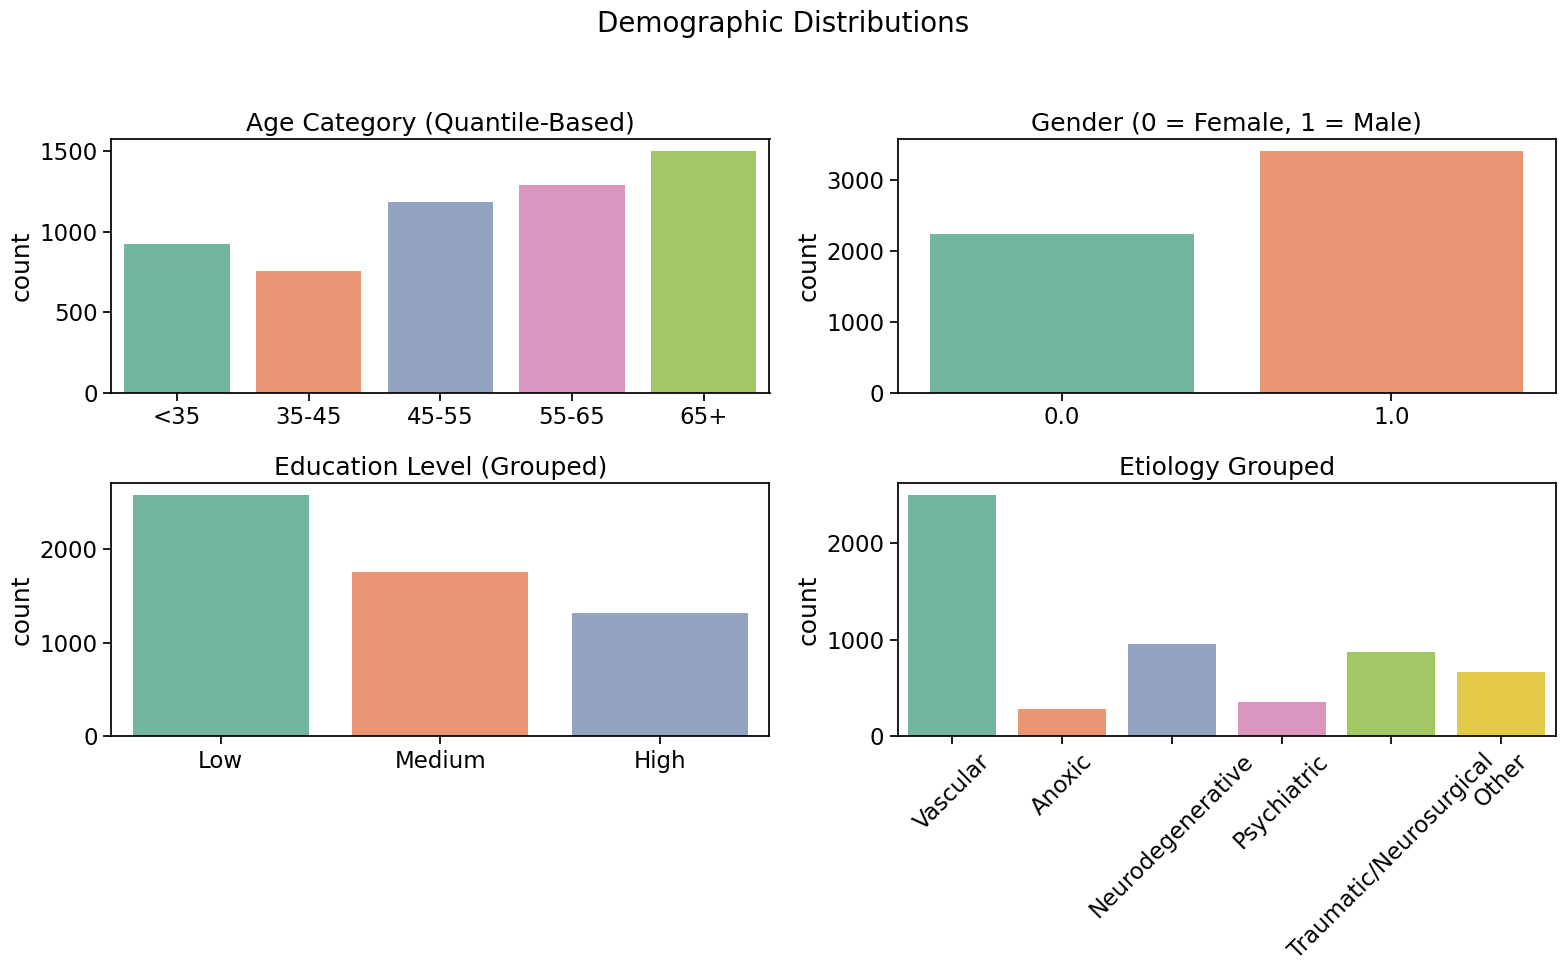

In [231]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Palette
palette_cb = sns.color_palette("Set2")

# Create a new column combining studies 0 and 1
df_merged_50['studies_grouped'] = df_merged_50['studies'].replace({0: 1})
df_merged_50['studies_grouped'] = df_merged_50['studies_grouped'].map({1: 'Low', 2: 'Medium', 3: 'High'})
sns.set_context("notebook", font_scale=1.5)


# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Demographic Distributions", fontsize=20)

# Age category (quantiles)
sns.countplot(
    ax=axs[0, 0],
    data=df_merged_50,
    x='age_category',
    order=age_labels,
    palette=palette_cb
)
axs[0, 0].set_title("Age Category (Quantile-Based)")
axs[0, 0].set_xlabel("")

# Gender
sns.countplot(
    ax=axs[0, 1],
    data=df_merged_50,
    x='is_male',
    palette=palette_cb
)
axs[0, 1].set_title("Gender (0 = Female, 1 = Male)")
axs[0, 1].set_xlabel("")

# Grouped education levels
sns.countplot(
    ax=axs[1, 0],
    data=df_merged_50,
    x='studies_grouped',
    order=['Low', 'Medium', 'High'],
    palette=palette_cb
)
axs[1, 0].set_title("Education Level (Grouped)")
axs[1, 0].set_xlabel("")

# Etiology grouped
etiology_order = [
    'Vascular', 'Anoxic', 'Neurodegenerative',
    'Psychiatric', 'Traumatic/Neurosurgical', 'Other'
]

sns.countplot(
    ax=axs[1, 1],
    data=df_merged_50,
    x='etiology_grouped',
    order=etiology_order,
    palette=palette_cb
)
axs[1, 1].set_title("Etiology Grouped")
axs[1, 1].tick_params(axis='x', rotation=45)
axs[1, 1].set_xlabel("")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [57]:
!pip install kmodes
from kmodes.kmodes import KModes



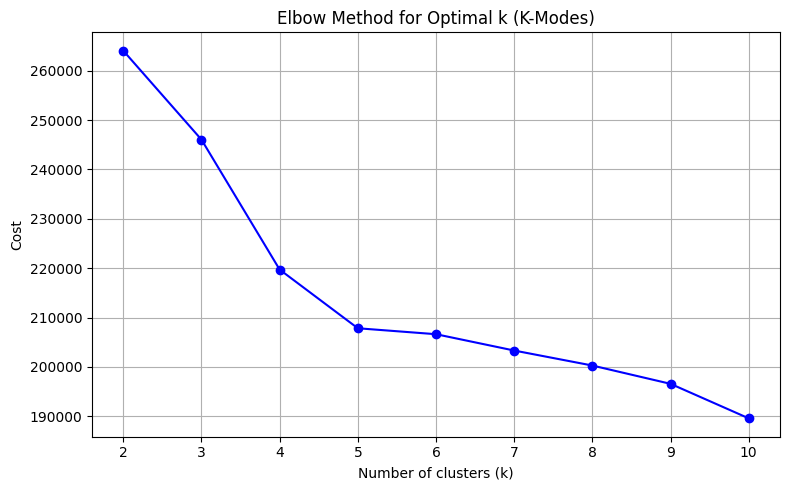

In [236]:
# Step 0: Define duplication factors for each etiology group
plt.rcdefaults()
duplication_factors = {
    'Vascular': 1,                      # no duplication
    'Traumatic/Neurosurgical': 2,      # duplicate once
    'Neurodegenerative': 2,
    'Other': 3,
    'Anoxic': 4,
    'Psychiatric': 4
}

# Create a list of dataframes, starting with the original dataset
duplicated_dfs = [df_merged_50]  # includes the original dataset

# Duplicate each group according to its assigned factor
for etiology, factor in duplication_factors.items():
    if factor > 1:
        subset = df_merged_50[df_merged_50['etiology_grouped'] == etiology]
        duplicated_dfs.extend([subset] * (factor - 1))

# Concatenate all dataframes into a single balanced dataset
df_merged_balanced = pd.concat(duplicated_dfs, ignore_index=True)


# Step 1: Define cognitive weights by function ID
functions_weights = {
    5: 2, 6: 2, 7: 2,                   # Atencio
    8: 2, 9: 2, 10: 2,                  # Memoria
    11: 1, 12: 1, 13: 1, 14: 1, 15: 1,  # Funcionsexecutives
    83: 6,                              # calculo
    85: 6,                              # gnoasis
    87: 6                               # orientacion
}


# Step 2: Define demographic weights (you can adjust these)
demographic_weights = {
    'age_category': 2,
    'is_male': 2,
    'studies': 2,
    'etiology_grouped': 2
}

# Step 3: Create weighted dataframe
X_df_weighted = df_merged_balanced[['idTreatment']].copy()

# Step 4: Add weighted cognitive functions
for func_id, weight in functions_weights.items():
    if func_id in df_merged_balanced.columns:
        for i in range(weight):
            col_name = f"{func_id}_rep{i+1}" if weight > 1 else str(func_id)
            X_df_weighted[col_name] = df_merged_balanced[func_id]

# Step 5: Add weighted demographic variables
for demo_var, weight in demographic_weights.items():
    if demo_var in df_merged_balanced.columns:
        for i in range(weight):
            col_name = f"{demo_var}_rep{i+1}" if weight > 1 else demo_var
            X_df_weighted[col_name] = df_merged_balanced[demo_var]

# Step 6: Convert to numpy matrix for KModes
X_weighted = X_df_weighted.drop('idTreatment', axis=1).astype(str).to_numpy()

# Optional: Elbow Method to find optimal number of clusters
costs = []
K = range(2, 11)  # You can adjust this range

for k in K:
    kmodes = KModes(n_clusters=k, init='Cao', n_init=5, verbose=0, random_state=42)
    kmodes.fit(X_weighted)
    costs.append(kmodes.cost_)

# Plot Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, costs, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k (K-Modes)')
plt.grid(True)
plt.tight_layout()
plt.show()


To address the imbalance in etiology distribution—especially the strong dominance of the “Vascular” group—we applied a targeted oversampling strategy. Rare groups such as "Anoxic" and "Psychiatric" were duplicated proportionally more to ensure they had sufficient representation in the clustering process. This helps the model avoid overfitting to the majority group and ensures that less frequent clinical profiles are adequately considered in the formation of clusters.

Additionally, we applied custom weights to cognitive and demographic variables to better reflect their importance in the clustering. For instance, functions like "Calculo", "Gnosias", and "Orientacion" were underrepresented in the dataset, so we increased their weight to avoid their dilution. Similarly, demographic variables such as age, education, sex, and etiology were also given higher weights to emphasize their relevance in patient profiling and improve cluster interpretability.

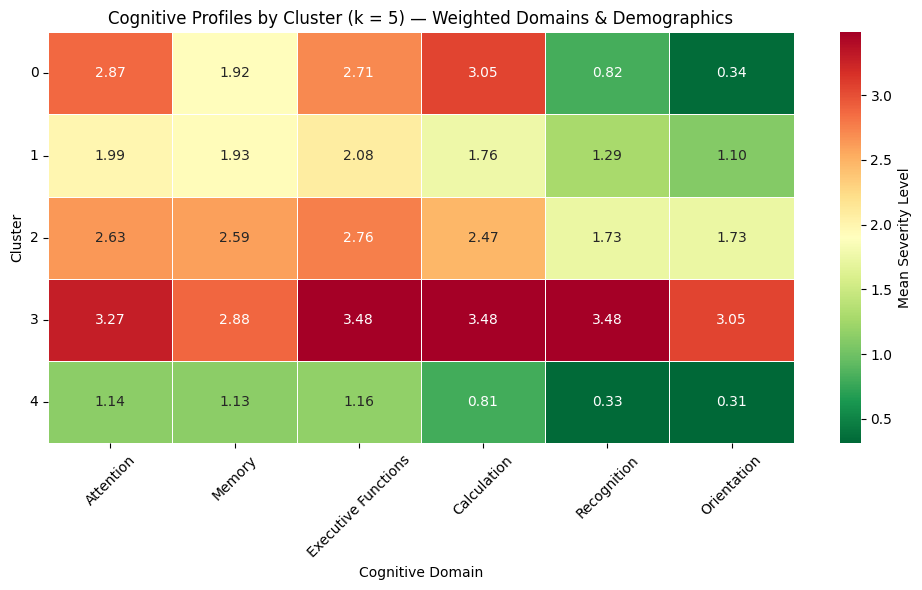

In [239]:
# Step 7: Clustering
k = 5
km = KModes(n_clusters=k, init='Cao', n_init=5, verbose=0, random_state=42)
clusters = km.fit_predict(X_weighted)

# Step 8: Assign clusters
df_merged_balanced[f'cluster_k{k}'] = clusters

# Step 9: Define updated cognitive macro-domains for analysis (post-clustering)
functions_map_50 = {
    'Attention': [5, 6, 7],
    'Memory': [8, 9, 10],
    'Executive Functions': [11, 12, 13, 14, 15],
    'Calculation': [83],
    'Recognition': [85],
    'Orientation': [87],
}

# Step 10: Compute post-cluster means for each domain
summary_post_cluster = pd.DataFrame()
for domain, ids in functions_map_50.items():
    cols = [col for col in ids if col in df_merged_balanced.columns]
    df_merged_balanced[cols] = df_merged_balanced[cols].apply(pd.to_numeric, errors='coerce')  # ensure numeric
    summary_post_cluster[domain] = df_merged_balanced.groupby(f'cluster_k{k}')[cols].mean().mean(axis=1)


# Add patient count per cluster
summary_post_cluster['n_patients'] = df_merged_balanced[f'cluster_k{k}'].value_counts().sort_index()

# Step 11: Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    summary_post_cluster.drop('n_patients', axis=1),
    annot=True,
    cmap='RdYlGn_r',
    linewidths=0.5,
    fmt=".2f",
    cbar_kws={'label': 'Mean Severity Level'}
)
plt.title(f'Cognitive Profiles by Cluster (k = {k}) — Weighted Domains & Demographics')
plt.xlabel('Cognitive Domain')
plt.ylabel('Cluster')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The clusters show clear cognitive differentiation:

Cluster 3 is the most impaired, with all domains averaging above 3.4.

Cluster 4 appears the most preserved, with values between 0.3 and 1.1 across domains.

Clusters 1 and 2 represent intermediate profiles with meaningful differences.

Cluster 0 shows a mixed pattern that may require further exploration.

Overall, the mean values across domains are well stratified, suggesting good cognitive separability between clusters.

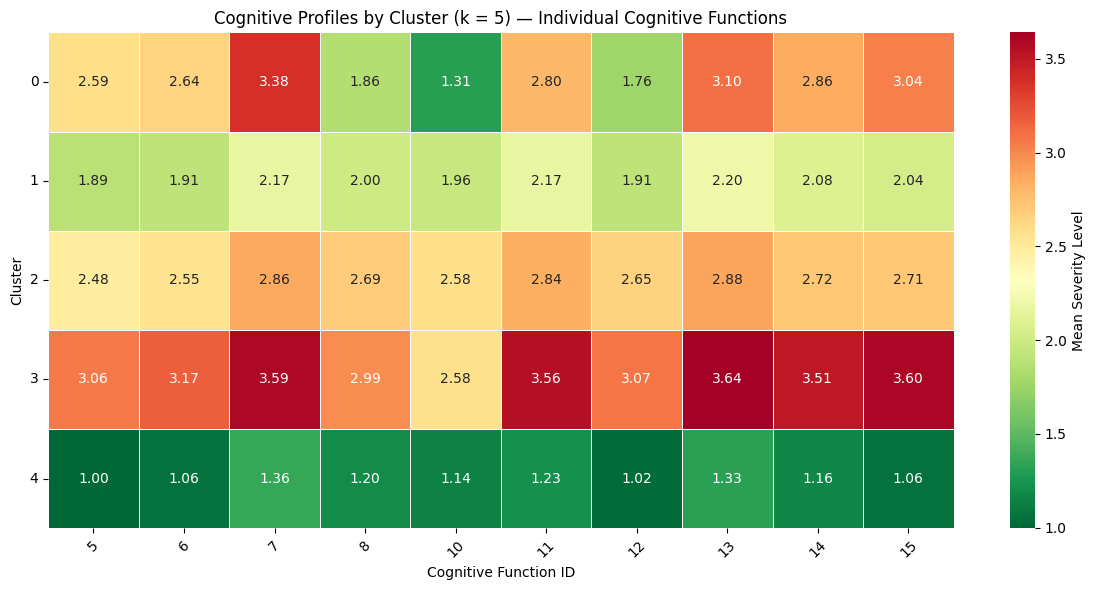

In [240]:
# Step 10 : Compute mean severity per individual function
individual_function_means = df_merged_balanced.groupby(f'cluster_k{k}')[
    [5, 6, 7, 8, 10, 11, 12, 13, 14, 15]
].mean()

# Step 11 : Plot heatmap for individual cognitive functions
plt.figure(figsize=(12, 6))
sns.heatmap(
    individual_function_means,
    annot=True,
    cmap='RdYlGn_r',
    linewidths=0.5,
    fmt=".2f",
    cbar_kws={'label': 'Mean Severity Level'}
)
plt.title(f'Cognitive Profiles by Cluster (k = {k}) — Individual Cognitive Functions')
plt.xlabel('Cognitive Function ID')
plt.ylabel('Cluster')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [60]:
# Step 8.1: Print number of patients per cluster
cluster_counts = df_merged_balanced[f'cluster_k{k}'].value_counts().sort_index()
print("Number of patients in each cluster:")
print(cluster_counts)


Number of patients in each cluster:
cluster_k5
0    2173
1    2435
2    1655
3    1897
4    2580
Name: count, dtype: int64


Figure X. Two-dimensional PCA projection of patient profiles using cognitive function scores. Points are colored by cluster, and ellipses represent the distribution of each group. Although the clusters show overlap, especially along PC2, a progressive separation is observed along PC1, which explains over 60% of the total variance. This suggests that the main component reflects a severity gradient, while finer distinctions may rely on additional dimensions.

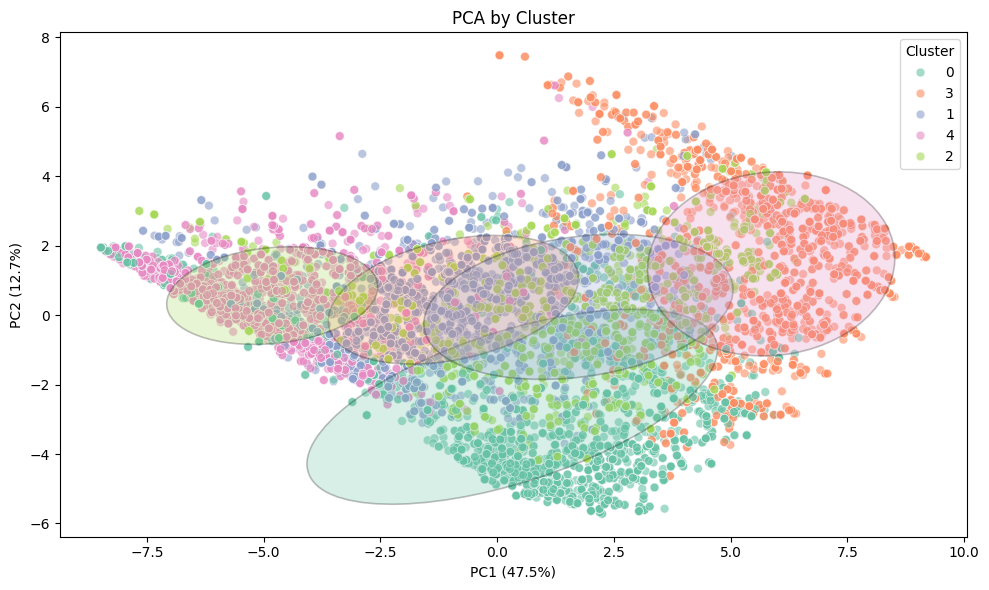

In [61]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

# Step 1: Prepara il dataframe pesato senza 'idTreatment'
X_weighted_pca = X_df_weighted.drop('idTreatment', axis=1).copy()
X_weighted_pca = X_weighted_pca.apply(pd.to_numeric, errors='coerce')

# Step 2: Elimina righe con troppi NaN (es. più del 50%)
row_nan_pct = X_weighted_pca.isna().mean(axis=1)
# Imputa con la media
X_weighted_pca = X_weighted_pca.fillna(X_weighted_pca.mean())

# Rimuovi eventuali colonne che non sono state imputate correttamente
X_weighted_pca = X_weighted_pca.dropna(axis=1)

# E alla fine elimina eventuali righe ancora incomplete
X_weighted_pca = X_weighted_pca.dropna()


# Step 3: Imputa i valori mancanti con la media
X_weighted_pca = X_weighted_pca.fillna(X_weighted_pca.mean())

# Step 4: Recupera le etichette di cluster corrispondenti
clusters_pca = df_merged_balanced.loc[X_weighted_pca.index, 'cluster_k5']

# Step 5: Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_weighted_pca)

# Step 6: PCA
pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(X_scaled)

# Step 7: DataFrame per il plot
pca_df = pd.DataFrame(data=X_pca_2d, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters_pca.values.astype(str)

# Funzione per disegnare le ellissi
def draw_ellipses(ax, data, group_col, x_col, y_col, color_map):
    for cluster in sorted(data[group_col].unique()):
        subset = data[data[group_col] == cluster]
        x = subset[x_col]
        y = subset[y_col]
        if len(x) > 1:
            cov = np.cov(x, y)
            lambda_, v = np.linalg.eig(cov)
            lambda_ = np.sqrt(lambda_)
            angle = np.rad2deg(np.arccos(v[0, 0]))
            ell = mpatches.Ellipse(
                xy=(x.mean(), y.mean()),
                width=lambda_[0]*2.5,
                height=lambda_[1]*2.5,
                angle=angle,
                edgecolor='black',
                facecolor=color_map[cluster],
                alpha=0.25,
                linewidth=1.2
            )
            ax.add_patch(ell)

# Step 8: Plot con ellissi
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set2', alpha=0.6, s=40)
palette = sns.color_palette('Set2', len(pca_df['Cluster'].unique()))
cluster_colors = dict(zip(sorted(pca_df['Cluster'].unique()), palette))
draw_ellipses(ax, pca_df, group_col='Cluster', x_col='PC1', y_col='PC2', color_map=cluster_colors)

plt.title('PCA by Cluster')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


This plot shows the PCA projection of all patients based on cognitive and demographic features, after applying the weighting scheme used for clustering. Each color represents one of the five clusters, and the ellipses indicate the general area covered by each group.

Cluster 4 (in pink, on the left) appears compact and distinct, which is consistent with its clinical profile: patients with minimal cognitive impairment and high levels of education. In contrast, Cluster 3 (in orange, on the right) is also well separated and includes patients with severe deficits, mostly with vascular or traumatic etiologies.

Cluster 0 (light green, large and stretched downward) is the most numerous and heterogeneous, including many older patients with vascular or anoxic conditions. Clusters 1 and 2 (purple and light green-yellow) are located near the center and overlap, reflecting their more mixed demographic and clinical characteristics.

Overall, while the central clusters are not fully separated, the PCA confirms meaningful differences across clusters—especially at the extremes—and supports the interpretability of the profiling approach.

In [63]:
loadings = pd.DataFrame(pca.components_.T,
                        columns=['PC1', 'PC2'],
                        index=X_weighted_pca.columns)

# Ordina per PC1
loadings_PC1_sorted = loadings['PC1'].abs().sort_values(ascending=False)
print("Top contributors to PC1:")
print(loadings_PC1_sorted.head(10))

# Ordina per PC2
loadings_PC2_sorted = loadings['PC2'].abs().sort_values(ascending=False)
print("\nTop contributors to PC2:")
print(loadings_PC2_sorted.head(10))


Top contributors to PC1:
83_rep2    0.187326
83_rep3    0.187326
83_rep1    0.187326
83_rep4    0.187326
83_rep6    0.187326
83_rep5    0.187326
11         0.180707
15         0.177514
13         0.175628
14         0.175585
Name: PC1, dtype: float64

Top contributors to PC2:
87_rep4    0.274131
87_rep1    0.274131
87_rep2    0.274131
87_rep3    0.274131
87_rep5    0.274131
87_rep6    0.274131
85_rep4    0.172949
85_rep5    0.172949
85_rep3    0.172949
85_rep6    0.172949
Name: PC2, dtype: float64


In [64]:
# Define demographic categorical variables
categorical_vars = ['age_category', 'is_male', 'studies_grouped', 'etiology_grouped']

# Loop through each variable and display distribution per cluster
for var in categorical_vars:
    print(f"\nDistribution of '{var}' by cluster:")
    display(pd.crosstab(df_merged_balanced[f'cluster_k{k}'], df_merged_balanced[var], normalize='index') * 100)



Distribution of 'age_category' by cluster:


age_category,<35,35-45,45-55,55-65,65+
cluster_k5,,,,,
0,14.956282,14.450069,30.280718,18.085596,22.227335
1,21.149897,14.537988,19.671458,22.833676,21.806982
2,31.480363,13.897281,14.078550,18.429003,22.114804
3,26.779125,16.868740,18.344755,15.498155,22.509225
4,18.178295,12.519380,19.728682,25.155039,24.418605



Distribution of 'is_male' by cluster:


is_male,0.0,1.0
cluster_k5,,
0,35.296825,64.703175
1,32.895277,67.104723
2,37.039275,62.960725
3,37.796521,62.203479
4,53.255814,46.744186



Distribution of 'studies_grouped' by cluster:


studies_grouped,Low,Medium,High
cluster_k5,,,
0,47.860101,29.728486,22.411413
1,49.650924,31.334702,19.014374
2,50.694864,29.184290,20.120846
3,48.603057,28.940432,22.456510
4,35.736434,34.728682,29.534884



Distribution of 'etiology_grouped' by cluster:


etiology_grouped,Anoxic,Neurodegenerative,Other,Psychiatric,Traumatic/Neurosurgical,Vascular
cluster_k5,,,,,,
0,23.561896,13.161528,11.734929,3.497469,19.420156,28.624022
1,7.556468,15.112936,18.234086,20.698152,13.223819,25.174538
2,7.734139,13.534743,28.096677,17.401813,15.468278,17.764350
3,9.699526,16.341592,19.609910,8.012652,23.405377,22.930944
4,5.736434,28.527132,17.674419,15.038760,12.248062,20.775194


Age, gender, and education levels are fairly balanced across clusters, indicating that these variables did not introduce noticeable bias.
Patients with higher education levels (e.g., study level 3.0) tend to concentrate in less impaired clusters (e.g., Cluster 4), which aligns with clinical expectations.

About Ethiolohy the oversampling strategy was effective:
The “Vascular” group no longer dominates the distribution.
Rarer etiologies (e.g., Psychiatric, Anoxic) are well represented across clusters.

Each cluster now includes a heterogeneous but interpretable mix of etiologies, which enhances the clinical relevance and robustness of the clustering outcome.

In [ ]:
import gower
from sklearn.metrics import silhouette_score

# Assicurati che tutte le variabili siano stringhe (necessario per gower)
X_gower_ready = X_df_weighted.drop('idTreatment', axis=1).astype(str)

# Calcola la matrice di distanza di Gower
gower_dist_matrix = gower.gower_matrix(X_gower_ready)

# Calcola silhouette score usando distanza precomputata
silhouette_avg = silhouette_score(gower_dist_matrix, clusters, metric='precomputed')

print(f"Silhouette score (con Gower distance) per k = {k}: {silhouette_avg:.3f}")



Silhouette score (con Gower distance) per k = 5: 0.167


## KMODES K=8

In [65]:
# 1. Pivot the dataframe: one row per treatment, one column per function
df_pivot_50 = df.pivot(index='idTreatment', columns='idFunction', values='resultNormalized').reset_index()

# 2. Calculate sparsity (percentage of NaN) for each function (column-wise)
sparsity_per_function_50 = df_pivot_50.drop('idTreatment', axis=1).isna().mean() * 100

# 3. Keep only functions with ≤50% missing values
threshold_50 = 50
functions_to_keep_50 = sparsity_per_function_50[sparsity_per_function_50 <= threshold_50].index.tolist()
df_pivot_filtered_50 = df_pivot_50[['idTreatment'] + functions_to_keep_50]

# REMOVE specific unwanted functions: 83 (Cálculo), 85 (Gnosias), 87 (Orientación)
functions_to_remove = [83, 85, 87]
df_pivot_filtered_50 = df_pivot_filtered_50.drop(columns=[f for f in functions_to_remove if f in df_pivot_filtered_50.columns])

# 4. Calculate sparsity for each treatment (row-wise) and filter those with ≤50% missing values
sparsity_per_patient_50 = df_pivot_filtered_50.drop('idTreatment', axis=1).isna().mean(axis=1) * 100

# Make a copy before modifying
df_pivot_filtered_50 = df_pivot_filtered_50.copy()
df_pivot_filtered_50['sparsity_percentage'] = sparsity_per_patient_50

# Apply final filter
df_pivot_filtered_50 = df_pivot_filtered_50[df_pivot_filtered_50['sparsity_percentage'] <= 50]
df_pivot_filtered_50 = df_pivot_filtered_50.drop('sparsity_percentage', axis=1)

# Optional: check average missingness
rowwise_nan_pct = df_pivot_filtered_50.drop('idTreatment', axis=1).isna().mean(axis=1) * 100
mean_nan_pct = rowwise_nan_pct.mean()
print(f"Mean missing percentage per treatment: {mean_nan_pct:.2f}%")


Mean missing percentage per treatment: 1.04%


In [66]:
df_pivot_filtered_50 = df_pivot_filtered_50.dropna()

In [67]:
# Step 5: Load function metadata and identify retained functions
functions_metadata = df[['idFunction', 'namePackage', 'macro_domain_corrected']].drop_duplicates()

# Step 6: Filter metadata to keep only retained functions
functions_metadata_filtered_50 = functions_metadata[functions_metadata['idFunction'].isin(functions_to_keep_50)]

# Step 7: Sort by macro domain for better readability
functions_metadata_filtered_50 = functions_metadata_filtered_50.sort_values(by='macro_domain_corrected')

# Step 8: Display the retained functions
print("Functions retained after applying the 50% sparsity filter:")
display(functions_metadata_filtered_50.reset_index(drop=True))

Functions retained after applying the 50% sparsity filter:


,idFunction,namePackage,macro_domain_corrected
0,6,Selectiva,Atencio
1,7,Dividida,Atencio
2,5,Sostinguda,Atencio
3,83,Mental,Calculo
4,11,Planificacio,Funcionsexecutives
5,12,Inhibicio,Funcionsexecutives
6,13,Flexibilitat,Funcionsexecutives
7,14,Sequenciacio,Funcionsexecutives
8,15,Categoritzacio,Funcionsexecutives
9,85,Visuales,Gnosias


/tmp/ipython-input-93-3708459965.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_data = df_filtered.groupby(['function_name', 'resultNormalized']).size().reset_index(name='count')


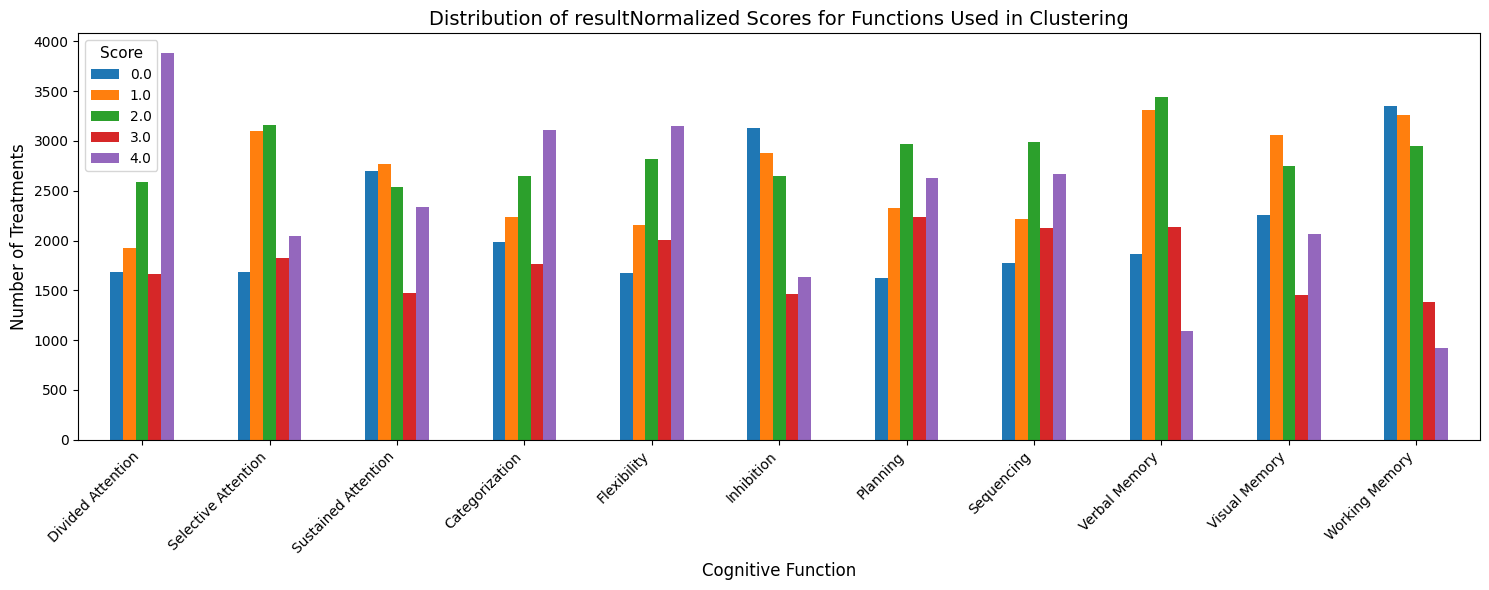

In [93]:
# Updated mapping from idFunction to readable names (in English)
function_labels = {
    5: 'Sustained Attention',
    6: 'Selective Attention',
    7: 'Divided Attention',
    8: 'Verbal Memory',
    9: 'Visual Memory',
    10: 'Working Memory',
    11: 'Planning',
    12: 'Inhibition',
    13: 'Flexibility',
    14: 'Sequencing',
    15: 'Categorization'
}

# Updated mapping from idFunction to macro domain (in English)
function_domains = {
    5: 'Attention',
    6: 'Attention',
    7: 'Attention',
    8: 'Memory',
    9: 'Memory',
    10: 'Memory',
    11: 'Executive Functions',
    12: 'Executive Functions',
    13: 'Executive Functions',
    14: 'Executive Functions',
    15: 'Executive Functions'
}



import matplotlib.pyplot as plt
import pandas as pd

# Filter the original dataframe to keep only selected functions
df_filtered = df[df['idFunction'].isin(function_labels.keys())].copy()

# Add readable function names and macro domains
df_filtered['function_name'] = df_filtered['idFunction'].map(function_labels)
df_filtered['macro_domain'] = df_filtered['idFunction'].map(function_domains)

# Count the number of occurrences for each function and resultNormalized value
count_data = df_filtered.groupby(['function_name', 'resultNormalized']).size().reset_index(name='count')

# Sort function names by domain for better visualization
function_order = pd.DataFrame.from_dict(function_domains, orient='index', columns=['domain'])
function_order['function_name'] = function_order.index.map(function_labels)
function_order = function_order.sort_values(by=['domain', 'function_name'])
ordered_names = function_order['function_name'].tolist()

# Pivot the table to prepare for plotting
count_pivot = count_data.pivot(index='function_name', columns='resultNormalized', values='count').fillna(0)
count_pivot = count_pivot.loc[ordered_names]

# Define a color-blind friendly palette
color_palette = plt.get_cmap('tab10')  # or 'Set2'

# Plot the bar chart
ax = count_pivot.plot(
    kind='bar',
    stacked=False,
    figsize=(15, 6),
    color=[color_palette(i) for i in range(count_pivot.shape[1])]
)

plt.title('Distribution of resultNormalized Scores for Functions Used in Clustering', fontsize=14)
plt.xlabel('Cognitive Function', fontsize=12)
plt.ylabel('Number of Treatments', fontsize=12)
plt.legend(title='Score', fontsize=10, title_fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [69]:
# 5. Merge the stricter filtered dataset with demographic variables
# 5. Compute the mode for each demographic variable grouped by idTreatment
demographic_cols = ['idTreatment', 'age_at_first_test', 'is_male', 'studies', 'ethiology']

demographics = (
    df[demographic_cols]
    .groupby('idTreatment')
    .agg(lambda x: x.mode().iloc[0])  # Prende la moda per ciascuna colonna
    .reset_index()
)
df_merged_50 = df_pivot_filtered_50.merge(demographics, on='idTreatment', how='left')

# Step 6 (updated): Categorize patient age based on quantiles
# Compute quantile-based bins
filtered_ages = df[df['idTreatment'].isin(df_pivot_filtered_50['idTreatment'])]['age_at_first_test']

# Define custom labels for the bins
age_labels = ['<35', '35-45', '45-55', '55-65', '65+']

# Define new age bins based on quantile cutoffs
age_bins = [0, 35, 45, 55, 65, 120]
age_labels = ['<35', '35-45', '45-55', '55-65', '65+']

df_merged_50['age_category'] = pd.cut(
    df_merged_50['age_at_first_test'],
    bins=age_bins,
    labels=age_labels,
    right=False
)

df_merged_50 = df_merged_50.drop('age_at_first_test', axis=1)

# 7. Create grouped etiology variable

etiology_map = {
    -1: None, 0: None, 7: None, # Exclude undefined and original "other"

    1: 'Vascular',
    2: 'Anoxic',
    3: 'Traumatic/Neurosurgical',
    4: 'Other',      # Tumor
    5: 'Neurodegenerative', 6: 'Neurodegenerative', 14: 'Neurodegenerative',
    15: 'Neurodegenerative', 16: 'Neurodegenerative', 17: 'Neurodegenerative',
    18: 'Neurodegenerative', 19: 'Neurodegenerative',
    9: 'Traumatic/Neurosurgical',  8: 'Other',
    10: 'Other',     # Paralisis
    11: 'Other',     # Neurodevelopmental
    13: 'Other',     # Neurodevelopmental
    22: 'Other',     # Neurodevelopmental
    23: 'Other',
    25: 'Other',
    12: 'Other',     # Epilepsia
    20: 'Psychiatric', 21: 'Psychiatric', 26: 'Psychiatric',
    27: 'Psychiatric', 28: 'Psychiatric'
}


# df_merged_50['etiology_grouped'] = df_merged_50['ethiology'].map(etiology_map)
df_merged_50['etiology_grouped'] = df_merged_50['ethiology'].map(etiology_map)
df_merged_50 = df_merged_50[df_merged_50['etiology_grouped'].notna()]


/tmp/ipython-input-70-3115872891.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_merged_50['studies_grouped'] = df_merged_50['studies'].replace({0: 1})
/tmp/ipython-input-70-3115872891.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axs[0, 0], data=df_merged_50, x='age_category',
/tmp/ipython-input-70-3115872891.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axs[0, 1], data=df_merged_50, x='is_male', palette='pastel')
/tmp/ipython-input-70-3115872891.

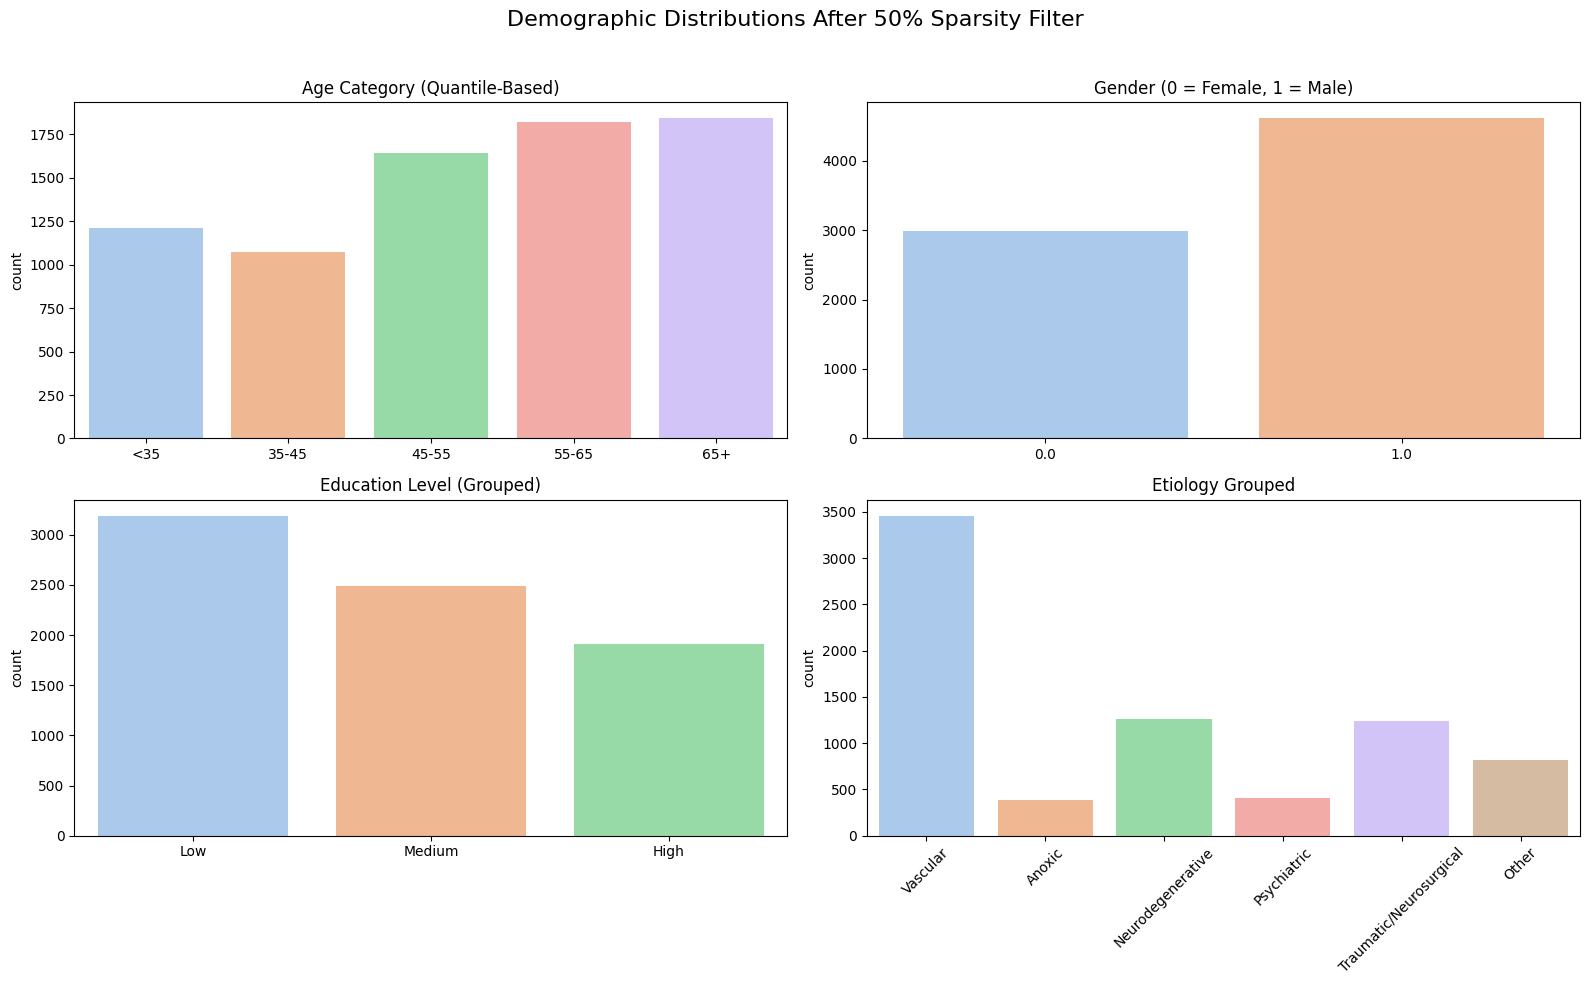

In [70]:
# Create a new column combining studies 0 and 1
df_merged_50['studies_grouped'] = df_merged_50['studies'].replace({0: 1})
df_merged_50['studies_grouped'] = df_merged_50['studies_grouped'].map({1: 'Low', 2: 'Medium', 3: 'High'})

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Demographic Distributions After 50% Sparsity Filter", fontsize=16)

# Age category (quantiles)
sns.countplot(ax=axs[0, 0], data=df_merged_50, x='age_category',
              order=age_labels, palette='pastel')
axs[0, 0].set_title("Age Category (Quantile-Based)")
axs[0, 0].set_xlabel("")

# Gender
sns.countplot(ax=axs[0, 1], data=df_merged_50, x='is_male', palette='pastel')
axs[0, 1].set_title("Gender (0 = Female, 1 = Male)")
axs[0, 1].set_xlabel("")

# Grouped education levels
sns.countplot(ax=axs[1, 0], data=df_merged_50, x='studies_grouped',
              order=['Low', 'Medium', 'High'], palette='pastel')
axs[1, 0].set_title("Education Level (Grouped)")
axs[1, 0].set_xlabel("")

# Etiology grouped
# etiology_order = ['Other', 'Neurodegenerative', 'Neurodevelopmental', 'Undefined',
                  # 'Psychiatric', 'Traumatic/Neurosurgical', 'Vascular/Anoxic']
etiology_order = [
    'Vascular', 'Anoxic', 'Neurodegenerative',
    'Psychiatric', 'Traumatic/Neurosurgical', 'Other'
]



sns.countplot(ax=axs[1, 1], data=df_merged_50, x='etiology_grouped',
              order=etiology_order, palette='pastel')
axs[1, 1].set_title("Etiology Grouped")
axs[1, 1].tick_params(axis='x', rotation=45)
axs[1, 1].set_xlabel("")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

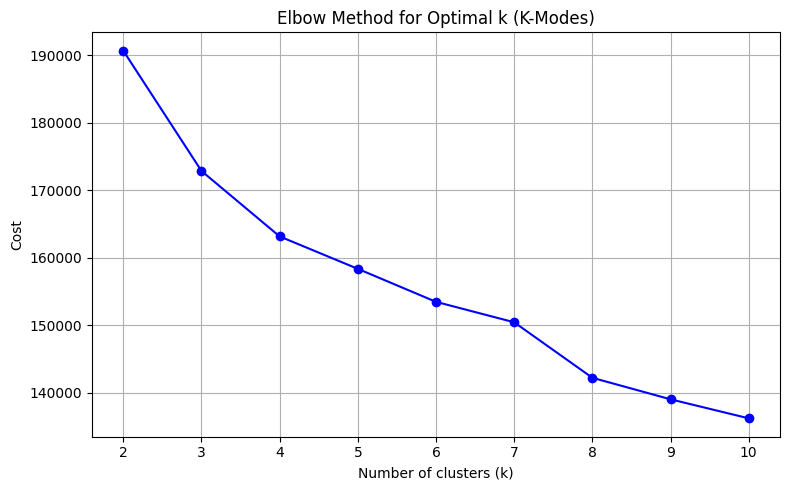

In [71]:
# Step 0: Define duplication factors for each etiology group
duplication_factors = {
    'Vascular': 1,                      # no duplication
    'Traumatic/Neurosurgical': 2,      # duplicate once
    'Neurodegenerative': 2,
    'Other': 3,
    'Anoxic': 4,
    'Psychiatric': 4
}

# Create a list of dataframes, starting with the original dataset
duplicated_dfs = [df_merged_50]  # includes the original dataset

# Duplicate each group according to its assigned factor
for etiology, factor in duplication_factors.items():
    if factor > 1:
        subset = df_merged_50[df_merged_50['etiology_grouped'] == etiology]
        duplicated_dfs.extend([subset] * (factor - 1))

# Concatenate all dataframes into a single balanced dataset
df_merged_balanced = pd.concat(duplicated_dfs, ignore_index=True)


# Step 1: Define cognitive weights by function ID
functions_weights = {
    5: 1, 6: 1, 7: 1,                   # Atencio
    8: 1, 9: 1, 10: 1,                  # Memoria
    11: 1, 12: 1, 13: 1, 14: 1, 15: 1,  # Funcionsexecutives
}


# Step 2: Define demographic weights (you can adjust these)
demographic_weights = {
    'age_category': 3,
    'is_male': 3,
    'studies_grouped': 3,
    'etiology_grouped': 3
}

# Step 3: Create weighted dataframe
X_df_weighted = df_merged_balanced[['idTreatment']].copy()

# Step 4: Add weighted cognitive functions
for func_id, weight in functions_weights.items():
    if func_id in df_merged_balanced.columns:
        for i in range(weight):
            col_name = f"{func_id}_rep{i+1}" if weight > 1 else str(func_id)
            X_df_weighted[col_name] = df_merged_balanced[func_id]

# Step 5: Add weighted demographic variables
for demo_var, weight in demographic_weights.items():
    if demo_var in df_merged_balanced.columns:
        for i in range(weight):
            col_name = f"{demo_var}_rep{i+1}" if weight > 1 else demo_var
            X_df_weighted[col_name] = df_merged_balanced[demo_var]

# Step 6: Convert to numpy matrix for KModes
X_weighted = X_df_weighted.drop('idTreatment', axis=1).astype(str).to_numpy()

# Optional: Elbow Method to find optimal number of clusters
costs = []
K = range(2, 11)  # You can adjust this range

for k in K:
    kmodes = KModes(n_clusters=k, init='Cao', n_init=5, verbose=0, random_state=42)
    kmodes.fit(X_weighted)
    costs.append(kmodes.cost_)

# Plot Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, costs, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k (K-Modes)')
plt.grid(True)
plt.tight_layout()
plt.show()


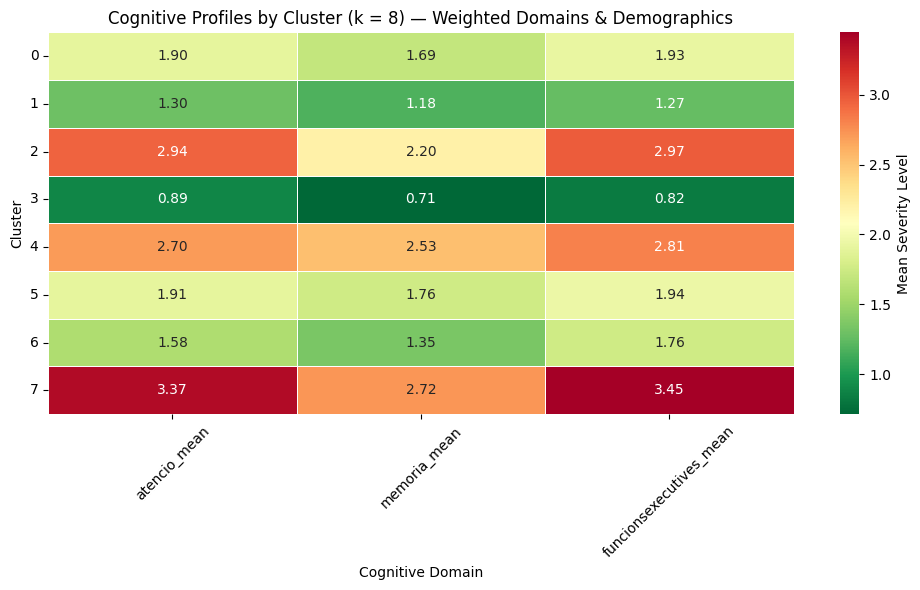

In [ ]:
# Step 7: Clustering
k = 8
km = KModes(n_clusters=k, init='Cao', n_init=5, verbose=0, random_state=42)
clusters = km.fit_predict(X_weighted)

# Step 8: Assign clusters
df_merged_balanced[f'cluster_k{k}'] = clusters

# Step 9: Define updated cognitive macro-domains for analysis (post-clustering)
functions_map_50 = {
    'atencio_mean': [5, 6, 7],
    'memoria_mean': [8, 9, 10],
    'funcionsexecutives_mean': [11, 12, 13, 14, 15]
}

# Step 10: Compute post-cluster means for each domain
summary_post_cluster = pd.DataFrame()
for domain, ids in functions_map_50.items():
    cols = [col for col in ids if col in df_merged_balanced.columns]
    df_merged_balanced[cols] = df_merged_balanced[cols].apply(pd.to_numeric, errors='coerce')  # ensure numeric
    summary_post_cluster[domain] = df_merged_balanced.groupby(f'cluster_k{k}')[cols].mean().mean(axis=1)


# Add patient count per cluster
summary_post_cluster['n_patients'] = df_merged_balanced[f'cluster_k{k}'].value_counts().sort_index()

# Step 11: Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    summary_post_cluster.drop('n_patients', axis=1),
    annot=True,
    cmap='RdYlGn_r',
    linewidths=0.5,
    fmt=".2f",
    cbar_kws={'label': 'Mean Severity Level'}
)
plt.title(f'Cognitive Profiles by Cluster (k = {k}) — Weighted Domains & Demographics')
plt.xlabel('Cognitive Domain')
plt.ylabel('Cluster')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The clusters show clear cognitive differentiation:

Cluster 3 is the most impaired, with all domains averaging above 3.4.

Cluster 4 appears the most preserved, with values between 0.3 and 1.1 across domains.

Clusters 1 and 2 represent intermediate profiles with meaningful differences.

Cluster 0 shows a mixed pattern that may require further exploration.

Overall, the mean values across domains are well stratified, suggesting good cognitive separability between clusters.

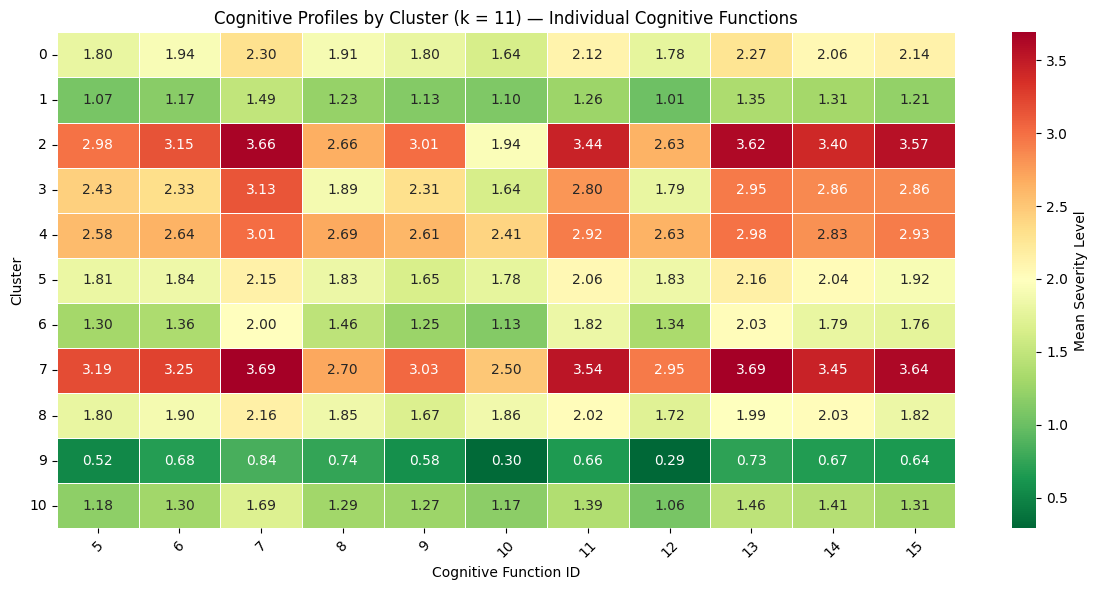

In [ ]:
# Step 10 : Compute mean severity per individual function
individual_function_means = df_merged_balanced.groupby(f'cluster_k{k}')[
    [5, 6, 7, 8,9, 10, 11, 12, 13, 14, 15]
].mean()

# Step 11 : Plot heatmap for individual cognitive functions
plt.figure(figsize=(12, 6))
sns.heatmap(
    individual_function_means,
    annot=True,
    cmap='RdYlGn_r',
    linewidths=0.5,
    fmt=".2f",
    cbar_kws={'label': 'Mean Severity Level'}
)
plt.title(f'Cognitive Profiles by Cluster (k = {k}) — Individual Cognitive Functions')
plt.xlabel('Cognitive Function ID')
plt.ylabel('Cluster')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# Define demographic categorical variables
categorical_vars = ['age_category', 'is_male', 'studies_grouped', 'etiology_grouped']

# Loop through each variable and display distribution per cluster
for var in categorical_vars:
    print(f"\nDistribution of '{var}' by cluster:")
    display(pd.crosstab(df_merged_balanced[f'cluster_k{k}'], df_merged_balanced[var], normalize='index') * 100)



Distribution of 'age_category' by cluster:


age_category,<35,35-45,45-55,55-65,65+
cluster_k8,,,,,
0,10.258809,9.666355,18.303711,46.024322,15.746804
1,10.909091,11.387560,20.574163,18.181818,38.947368
2,18.251144,14.184037,48.042705,12.913066,6.609049
3,31.863354,15.714286,19.689441,17.701863,15.031056
4,24.870466,17.227979,11.528497,14.183938,32.189119
5,63.905325,10.228233,14.454776,5.071851,6.339814
6,13.372093,45.639535,19.573643,12.500000,8.914729
7,13.890762,13.890762,13.014160,15.643965,43.560351



Distribution of 'is_male' by cluster:


is_male,0.0,1.0
cluster_k8,,
0,24.415341,75.584659
1,69.425837,30.574163
2,15.099136,84.900864
3,68.881988,31.118012
4,22.344560,77.655440
5,27.895182,72.104818
6,21.414729,78.585271
7,73.162508,26.837492



Distribution of 'studies_grouped' by cluster:


studies_grouped,Low,Medium,High
cluster_k8,,,
0,67.602120,16.931712,15.466168
1,27.990431,50.239234,21.770335
2,23.385867,58.871378,17.742755
3,17.329193,22.857143,59.813665
4,69.430052,16.709845,13.860104
5,12.510566,78.529163,8.960270
6,16.860465,14.244186,68.895349
7,76.534053,9.238031,14.227916



Distribution of 'etiology_grouped' by cluster:


etiology_grouped,Anoxic,Neurodegenerative,Other,Psychiatric,Traumatic/Neurosurgical,Vascular
cluster_k8,,,,,,
0,9.229810,13.221079,13.844715,9.978173,9.853446,43.872778
1,6.889952,45.263158,11.626794,8.803828,8.708134,18.708134
2,17.488561,9.150991,12.201322,3.457041,43.111337,14.590747
3,10.931677,19.254658,32.422360,4.968944,13.291925,19.130435
4,10.362694,14.507772,16.321244,14.766839,29.274611,14.766839
5,4.395604,7.607777,13.693998,51.056636,18.934911,4.311074
6,12.790698,10.852713,38.953488,5.813953,17.054264,14.534884
7,15.913688,16.722859,13.755900,5.394471,5.124747,43.088334


Age, gender, and education levels are fairly balanced across clusters, indicating that these variables did not introduce noticeable bias.
Patients with higher education levels (e.g., study level 3.0) tend to concentrate in less impaired clusters (e.g., Cluster 4), which aligns with clinical expectations.

About Ethiolohy the oversampling strategy was effective:
The “Vascular” group no longer dominates the distribution.
Rarer etiologies (e.g., Psychiatric, Anoxic) are well represented across clusters.

Each cluster now includes a heterogeneous but interpretable mix of etiologies, which enhances the clinical relevance and robustness of the clustering outcome.

In [ ]:
# pip install gower


In [ ]:
# import gower
# from sklearn.metrics import silhouette_score

# # Assicurati che tutte le variabili siano stringhe (necessario per gower)
# X_gower_ready = X_df_weighted.drop('idTreatment', axis=1).astype(str)

# # Calcola la matrice di distanza di Gower
# gower_dist_matrix = gower.gower_matrix(X_gower_ready)

# # Calcola silhouette score usando distanza precomputata
# silhouette_avg = silhouette_score(gower_dist_matrix, clusters, metric='precomputed')

# print(f"Silhouette score (con Gower distance) per k = {k}: {silhouette_avg:.3f}")



Silhouette score (con Gower distance) per k = 5: 0.167


The silhouette score obtained for k=5 was 0.167, indicating a relatively weak clustering structure. This outcome is, however, expected given the clinical nature of the dataset, where patient profiles often present overlapping characteristics and gradual variations rather than distinct group boundaries. Therefore, the interpretability and clinical relevance of the resulting clusters are considered more important than a high silhouette value

# TASK ASSIGMENT

## USAGE SCORE

In [73]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore

# Set base path in your Drive
base_path = "/content/drive/MyDrive"

# Load input data (use sampled version for block_tasks)
block_tasks = pd.read_csv(f"{base_path}/block_tasks_sampled.csv")
blocks = pd.read_csv(f"{base_path}/blocks.csv")
sessions = pd.read_csv(f"{base_path}/sessions_clean.csv")
clusters = pd.read_csv(f"{base_path}/df_merged_clustered_k5.csv")
admin_data = pd.read_csv(f"{base_path}/administrative_data.csv")
tasks_to_score = pd.read_csv(f"{base_path}/tasks_to_be_scored.csv")

# Rename columns in administrative data for clarity
admin_data.columns = [
    "treatment_id", "patient_id", "center_id", "area_id", "category_id", "regime_id",
    "therapeutic_days", "sessions_paid", "literacy", "etiology", "other",
    "injury_date", "start_treatment", "end_treatment", "pre_intervention_start",
    "global_improvement", "treatment_completed"
]

# Filter the list of 208 tasks to be scored
task_ids = tasks_to_score['idTask'].unique()

# STEP 1: Merge to associate each task with its treatment and cluster
task_treatment_data = block_tasks.merge(blocks[['idBlock', 'idSession']], on='idBlock', how='left') \
                                 .merge(sessions[['idSession', 'idTreatment']], on='idSession', how='left') \
                                 .merge(clusters[['idTreatment', 'cluster_k5']], on='idTreatment', how='left') \
                                 .merge(admin_data[['treatment_id', 'category_id']],
                                        left_on='idTreatment', right_on='treatment_id', how='left')

# Check: ensure that no merging step has dropped all rows
assert task_treatment_data.shape[0] > 0, "The merged DataFrame is empty — check merge keys or data integrity."

# STEP 2: Keep only patients in DCA category (category_id = 1) and relevant tasks
task_treatment_data = task_treatment_data[
    (task_treatment_data['category_id'] == 1) & (task_treatment_data['idTask'].isin(task_ids))
]

# Check: ensure filtering retains enough data
assert task_treatment_data.shape[0] > 0, "Filtering removed all rows — check 'category_id' or task IDs."

# Keep only the necessary columns
task_treatment_data = task_treatment_data[['idTask', 'idTreatment', 'cluster_k5']]

# STEP 3: Count the number of times each task has been used in each cluster
usage_counts = task_treatment_data.groupby(['idTask', 'cluster_k5']).size().reset_index(name='n_uses')

# STEP 4: Compute the z-score of usage per cluster
usage_counts['usage_zscore'] = usage_counts.groupby('cluster_k5')['n_uses'].transform(zscore)

# STEP 5: Normalize the z-score into a 1–4 range within each cluster
# Comment: usage_score indicates how frequently a task is used in a specific cluster,
# relative to the average usage of all tasks in that cluster.
# A value close to 4 means that the task is among the most used in that cluster.
usage_counts['usage_score'] = usage_counts.groupby('cluster_k5')['usage_zscore'] \
    .transform(lambda x: MinMaxScaler(feature_range=(1, 4)).fit_transform(x.values.reshape(-1, 1)).flatten())

# STEP 6: Preview the usage scores
usage_counts[['idTask', 'cluster_k5', 'n_uses', 'usage_zscore', 'usage_score']].head()

/tmp/ipython-input-73-3129378381.py:11: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  block_tasks = pd.read_csv(f"{base_path}/block_tasks_sampled.csv")
/tmp/ipython-input-73-3129378381.py:13: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  sessions = pd.read_csv(f"{base_path}/sessions_clean.csv")


,idTask,cluster_k5,n_uses,usage_zscore,usage_score
0,93.0,0.0,373,0.562082,2.180952
1,93.0,1.0,373,0.489936,2.472296
2,93.0,2.0,238,0.361882,2.304587
3,93.0,3.0,301,0.463844,2.033295
4,93.0,4.0,507,0.428152,2.521042


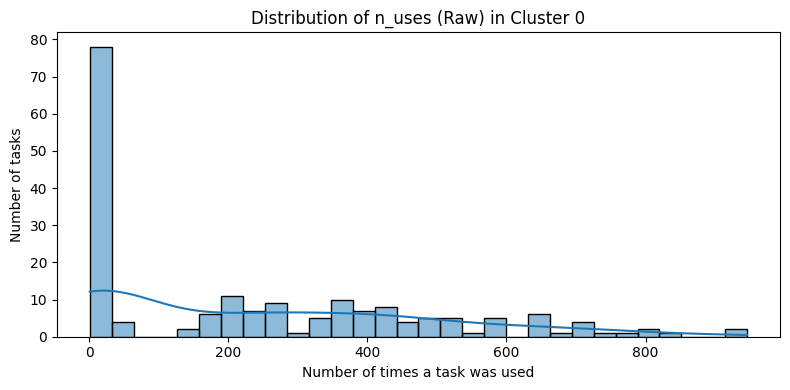

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(data=usage_counts[usage_counts['cluster_k5'] == 0], x='n_uses', bins=30, kde=True)
plt.title("Distribution of n_uses (Raw) in Cluster 0")
plt.xlabel("Number of times a task was used")
plt.ylabel("Number of tasks")
plt.tight_layout()
plt.show()

In [75]:
# Calculate usage_score using quartiles (as in DSS 2014)
def assign_quartile_score(x):
    return pd.qcut(x, q=4, labels=[1, 2, 3, 4])

usage_score_original = usage_counts.copy()
usage_score_original['usage_score_original'] = usage_score_original.groupby('cluster_k5')['n_uses'] \
    .transform(assign_quartile_score).astype(int)

# Preview
usage_score_original[['idTask', 'cluster_k5', 'n_uses', 'usage_score_original']].head()

,idTask,cluster_k5,n_uses,usage_score_original
0,93.0,0.0,373,3
1,93.0,1.0,373,3
2,93.0,2.0,238,3
3,93.0,3.0,301,3
4,93.0,4.0,507,3


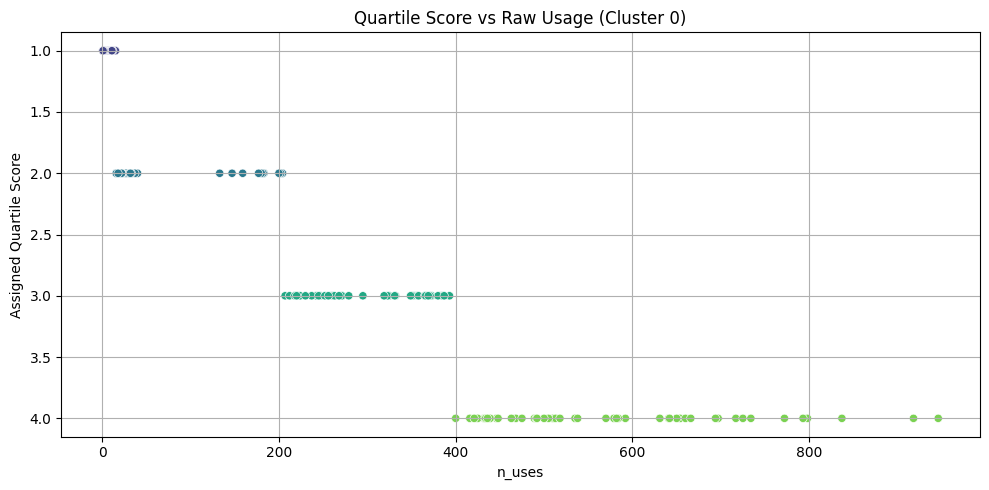

In [76]:
# Assign quartiles in cluster 0
q_data = usage_counts[usage_counts['cluster_k5'] == 0].copy()
q_data['quartile_score'] = pd.qcut(q_data['n_uses'], 4, labels=[1, 2, 3, 4])

plt.figure(figsize=(10, 5))
sns.scatterplot(data=q_data, x='n_uses', y='quartile_score', hue='quartile_score', palette='viridis', legend=False)
plt.title("Quartile Score vs Raw Usage (Cluster 0)")
plt.xlabel("n_uses")
plt.ylabel("Assigned Quartile Score")
plt.grid(True)
plt.tight_layout()
plt.show()

From the scatterplot, we observe that all tasks above ~400 uses are grouped into the same quartile (Q4), despite some having more than twice the usage of others. This compresses the upper tail of the distribution and reduces the scoring resolution for high-usage tasks. Quartiles fail to capture these meaningful differences — which a z-score or log-transformation can reflect more accurately.

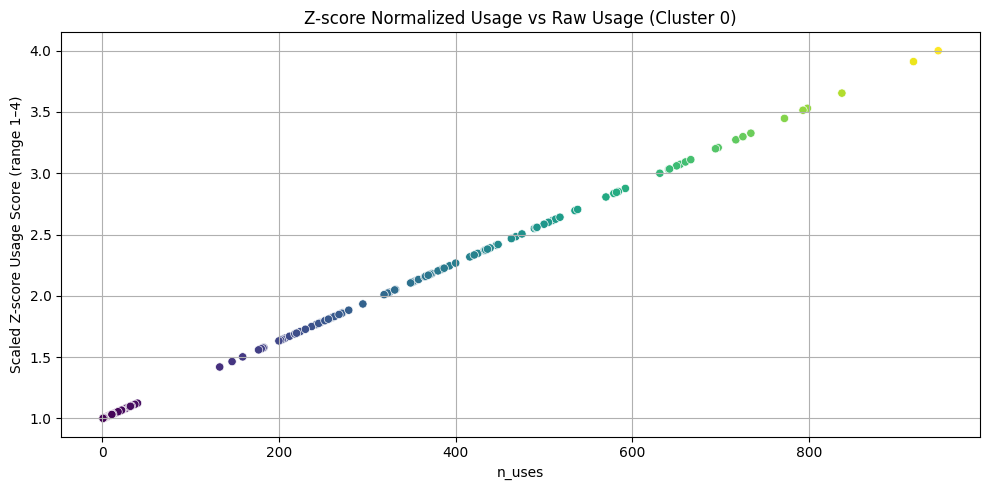

In [77]:
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the z-score for cluster 0
z_data = usage_counts[usage_counts['cluster_k5'] == 0].copy()
z_data['z_score'] = zscore(z_data['n_uses'])

# Normalize the z-score on a 1–4 scale
from sklearn.preprocessing import MinMaxScaler
z_data['z_score_scaled'] = MinMaxScaler(feature_range=(1, 4)).fit_transform(z_data[['z_score']])

# Scatterplot: n_uses vs z_score_scaled
plt.figure(figsize=(10, 5))
sns.scatterplot(data=z_data, x='n_uses', y='z_score_scaled', hue='z_score_scaled', palette='viridis', legend=False)
plt.title("Z-score Normalized Usage vs Raw Usage (Cluster 0)")
plt.xlabel("n_uses")
plt.ylabel("Scaled Z-score Usage Score (range 1–4)")
plt.grid(True)
plt.tight_layout()
plt.show()

Compared to quartile-based scoring, z-score normalization provides a smoother and more proportional representation of task usage. While quartiles group tasks into rigid categories regardless of their distance, z-score captures subtle variations and respects the true statistical distance from the mean. This allows for more nuanced prioritization in task selection, particularly useful in skewed distributions like those observed in usage data.

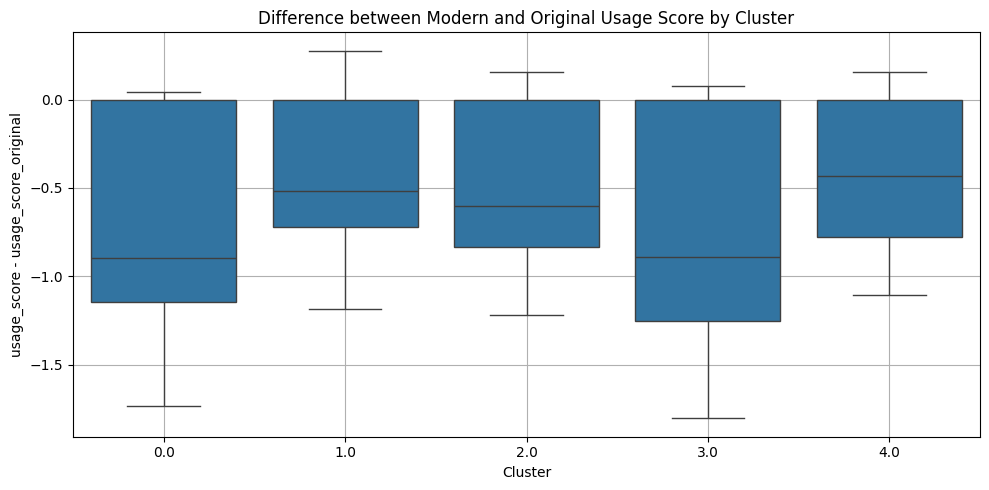

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(data=usage_comparison, x='cluster_k5', y='usage_diff')
plt.title("Difference between Modern and Original Usage Score by Cluster")
plt.xlabel("Cluster")
plt.ylabel("usage_score - usage_score_original")
plt.grid(True)
plt.tight_layout()
plt.show()

The boxplot shows the distribution of changes between the modern usage score (z-score based) and the original quartile-based score, for each cluster. In all clusters, the median difference is negative, indicating that most tasks received slightly lower scores in the new system. This reflects a correction of the previous overestimation: the quartile system often assigned the maximum score (4) to tasks that were not truly among the most used. At the same time, the presence of positive outliers shows that less-used tasks can now receive more nuanced scores, improving resolution and fairness.

## IMPROVEMENT SCORE

### Nuovo

In [81]:
import pandas as pd

# Load tasks and function improvement file from Google Drive
tasks_208 = tasks_to_score.copy()  # already filtered 208 tasks
function_improvement = pd.read_csv(f"{base_path}/function_improvement.csv")

# Define main cognitive domains and their subfunctions
main_domains = {
    'attention': [5, 6, 7],
    'memory': [8, 9, 10],
    'executive_functions': [11, 12, 13, 14, 15]
}

# Create inverse mapping: subfunction → main domain
subfunction_to_domain = {
    sub: domain
    for domain, subfunctions in main_domains.items()
    for sub in subfunctions
}

# Minimum number of patients required for score
min_patients = 10

# Store results
improvement_scores = []

# Loop through tasks
for _, task_row in tasks_208.iterrows():
    task_id = task_row['idTask']
    subfunction = task_row['idFunction']

    # Skip tasks not in defined domains
    if subfunction not in subfunction_to_domain:
        continue

    main_domain = subfunction_to_domain[subfunction]
    other_domains = [d for d in main_domains if d != main_domain]
    F_subfunctions = [f for f in main_domains[main_domain] if f != subfunction]

    # Loop through clusters
    for cluster in task_treatment_data['cluster_k5'].dropna().unique():
        subset = task_treatment_data[
            (task_treatment_data['idTask'] == task_id) &
            (task_treatment_data['cluster_k5'] == cluster)
        ]
        patients = subset['idTreatment'].dropna().unique()

        if len(patients) < min_patients:
            continue

        cluster_improvements = function_improvement[
            function_improvement['idTreatment'].isin(patients)
        ]

        # Helper function to calculate % improved
        def pct_improved(function_ids):
            values = cluster_improvements[
                cluster_improvements['idFunction'].isin(function_ids)
            ]['result']
            return (values > 0).sum() / len(patients) if len(patients) > 0 else 0

        # Compute 4 improvement criteria
        s_improved = pct_improved([subfunction]) > 0.5
        f_improved = pct_improved(F_subfunctions) > 0.5
        m1_improved = pct_improved(main_domains[other_domains[0]]) > 0.5
        m2_improved = pct_improved(main_domains[other_domains[1]]) > 0.5

        score = sum([s_improved, f_improved, m1_improved, m2_improved])

        improvement_scores.append({
            'idTask': task_id,
            'cluster_k5': cluster,
            'n_patients': len(patients),
            'improvement_score': score
        })

# Convert to DataFrame
df_improvement_score = pd.DataFrame(improvement_scores)

# Preview
df_improvement_score.head()


,idTask,cluster_k5,n_patients,improvement_score
0,146,4.0,194,1
1,146,1.0,123,1
2,146,2.0,85,1
3,146,0.0,155,3
4,146,3.0,123,1


### Vecchio

In [82]:
improvement_scores_original = []

for _, task_row in tasks_208.iterrows():
    task_id = task_row['idTask']
    subfunction = task_row['idFunction']

    if subfunction not in subfunction_to_domain:
        continue

    main_domain = subfunction_to_domain[subfunction]
    others = [d for d in main_domains if d != main_domain]
    F_subfunctions = [f for f in main_domains[main_domain] if f != subfunction]

    for cluster in task_treatment_data['cluster_k5'].dropna().unique():
        subset = task_treatment_data[
            (task_treatment_data['idTask'] == task_id) &
            (task_treatment_data['cluster_k5'] == cluster)
        ]
        patients = subset['idTreatment'].dropna().unique()

        cluster_improvements = function_improvement[
            function_improvement['idTreatment'].isin(patients)
        ]

        def pct_improved(function_ids):
            values = cluster_improvements[
                cluster_improvements['idFunction'].isin(function_ids)
            ]['result']
            return (values > 0).sum() / len(patients) if len(patients) > 0 else 0

        s_improved = pct_improved([subfunction]) > 0.5
        f_improved = pct_improved(F_subfunctions) > 0.5
        m1_improved = pct_improved(main_domains[others[0]]) > 0.5
        m2_improved = pct_improved(main_domains[others[1]]) > 0.5

        score = sum([s_improved, f_improved, m1_improved, m2_improved])

        improvement_scores_original.append({
            'idTask': task_id,
            'cluster_k5': cluster,
            'improvement_score_original': score
        })

df_improvement_score_original = pd.DataFrame(improvement_scores_original)


# Preview
df_improvement_score_original.head()


,idTask,cluster_k5,improvement_score_original
0,146,4.0,1
1,146,1.0,1
2,146,2.0,1
3,146,0.0,3
4,146,3.0,1


## CLINICAL SCORE

### Nuovo

In [83]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# === Configurable parameters ===
NA_WEIGHT = 2
CC_WEIGHT = 1
AGE_RANGE = 0  # 0 = adults

# === Load data from your base path in Google Drive ===
tasks = pd.read_csv(f"{base_path}/tasks_to_be_scored.csv")
suitability = pd.read_csv(f"{base_path}/tasks_suitability.csv")
clusters = pd.read_csv(f"{base_path}/df_merged_clustered_k5.csv")
function_data = pd.read_csv(f"{base_path}/function_levels.csv")

# Rename columns for clarity
function_data.columns = ["level_id", "function_id", "treatment_id", "value_type", "normalized_result"]
function_data['normalized_result'] = pd.to_numeric(function_data['normalized_result'], errors='coerce')

# Filter suitability data to adults only
suitability_adults = suitability[suitability['ageRange'] == AGE_RANGE]

# Compute clinical scores
clinical_scores = []

for _, task_row in tasks.iterrows():
    task_id = task_row['idTask']
    main_function = int(task_row['idFunction'])  # main subfunction

    # Filter suitability info for this task
    suitability_row = suitability_adults[suitability_adults['idTask'] == task_id]
    if suitability_row.empty:
        continue

    suitability_map = suitability_row.set_index('idFunction')['suitability'].to_dict()

    for cluster in clusters['cluster_k5'].dropna().unique():
        patients_in_cluster = clusters[clusters['cluster_k5'] == cluster]['idTreatment'].unique()
        cluster_function_data = function_data[function_data['treatment_id'].isin(patients_in_cluster)]

        # NA: affectation level of the main subfunction
        main_affectation = cluster_function_data[
            (cluster_function_data['function_id'] == main_function) &
            (cluster_function_data['normalized_result'] != -2)
        ]['normalized_result']

        if main_affectation.empty:
            continue

        NA = main_affectation.mean() * NA_WEIGHT

        # CC: clinical relevance based on other subfunctions
        CC = 0
        for func_id, suitability_score in suitability_map.items():
            if func_id == main_function:
                continue
            sub_vals = cluster_function_data[
                (cluster_function_data['function_id'] == func_id) &
                (cluster_function_data['normalized_result'] != -2)
            ]['normalized_result']
            if sub_vals.empty:
                continue
            CC += sub_vals.mean() * suitability_score * CC_WEIGHT

        clinical_scores.append({
            'idTask': task_id,
            'cluster_k5': cluster,
            'n_patients': len(patients_in_cluster),
            'raw_clinical_score': NA + CC
        })

# Create DataFrame from results
df_clinical_score = pd.DataFrame(clinical_scores)

# Normalize the raw clinical score between 0 and 4 within each cluster
df_clinical_score['clinical_score'] = df_clinical_score.groupby('cluster_k5')['raw_clinical_score'] \
    .transform(lambda x: MinMaxScaler(feature_range=(0, 4)).fit_transform(x.values.reshape(-1, 1)).flatten())

# Round to 2 decimals
df_clinical_score['clinical_score'] = df_clinical_score['clinical_score'].round(2)

# Preview the result
df_clinical_score[['idTask', 'cluster_k5', 'n_patients', 'clinical_score']].head()


/tmp/ipython-input-83-2908888765.py:13: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  function_data = pd.read_csv(f"{base_path}/function_levels.csv")


,idTask,cluster_k5,n_patients,clinical_score
0,146,0,1208,1.51
1,146,3,1020,1.06
2,146,1,1277,1.17
3,146,4,1348,1.23
4,146,2,794,1.19


### Vecchio

In [84]:
clinical_scores_original = []

for _, task_row in tasks.iterrows():
    task_id = task_row['idTask']
    main_function = int(task_row['idFunction'])

    suitability_row = suitability_adults[suitability_adults['idTask'] == task_id]
    if suitability_row.empty:
        continue

    suitability_map = suitability_row.set_index('idFunction')['suitability'].to_dict()

    for cluster in clusters['cluster_k5'].dropna().unique():
        patients = clusters[clusters['cluster_k5'] == cluster]['idTreatment'].unique()
        cluster_data = function_data[function_data['treatment_id'].isin(patients)]

        main_affectation = cluster_data[
            (cluster_data['function_id'] == main_function) &
            (cluster_data['normalized_result'] != -2)
        ]['normalized_result']

        if main_affectation.empty:
            continue

        NA = main_affectation.mean() * NA_WEIGHT

        CC = 0
        for func_id, suitability_score in suitability_map.items():
            if func_id == main_function:
                continue
            vals = cluster_data[
                (cluster_data['function_id'] == func_id) &
                (cluster_data['normalized_result'] != -2)
            ]['normalized_result']
            if vals.empty:
                continue
            CC += vals.mean() * suitability_score * CC_WEIGHT

        clinical_scores_original.append({
            'idTask': task_id,
            'cluster_k5': cluster,
            'clinical_score_original': NA + CC
        })

df_clinical_score_original = pd.DataFrame(clinical_scores_original)


## FINAL GIP SCORE

### Nuovo

In [85]:
import numpy as np
import os

# Merge the available scores: usage, improvement, clinical
df_all_scores = usage_counts.merge(df_improvement_score, on=['idTask', 'cluster_k5'], how='left') \
                            .merge(df_clinical_score[['idTask', 'cluster_k5', 'clinical_score']],
                                   on=['idTask', 'cluster_k5'], how='left')

# Step 1.5: Create a column indicating which scores are available for each task-cluster
def get_score_code(row):
    return ''.join([
        'C' if not pd.isna(row['clinical_score']) else '',
        'U' if not pd.isna(row['usage_score']) else '',
        'M' if not pd.isna(row['improvement_score']) else ''
    ])
df_all_scores['score_available'] = df_all_scores.apply(get_score_code, axis=1)

# Step 2: Define weights per cluster
cluster_weights = {
    0: {'w_usage': 0.2, 'w_improvement': 0.6, 'w_clinical': 0.2},
    1: {'w_usage': 0.3, 'w_improvement': 0.5, 'w_clinical': 0.2},
    2: {'w_usage': 0.4, 'w_improvement': 0.4, 'w_clinical': 0.2},
    3: {'w_usage': 0.0, 'w_improvement': 0.7, 'w_clinical': 0.3},
    4: {'w_usage': 0.5, 'w_improvement': 0.1, 'w_clinical': 0.4},
}

# Step 3: Calculate the GIp using only the available scores
def compute_gip(row):
    w = cluster_weights[int(row['cluster_k5'])]
    gip = 0
    has_score = False

    if not pd.isna(row['usage_score']):
        gip += w['w_usage'] * row['usage_score']
        has_score = True
    if not pd.isna(row['improvement_score']):
        gip += w['w_improvement'] * row['improvement_score']
        has_score = True
    if not pd.isna(row['clinical_score']):
        gip += w['w_clinical'] * row['clinical_score']
        has_score = True

    return gip if has_score else np.nan

# Apply the GIp formula
df_all_scores['GIp'] = df_all_scores.apply(compute_gip, axis=1)

# Step 4: Round numerical columns
df_all_scores = df_all_scores.round(2)

# Step 5: Save to Google Drive
output_path = os.path.join(base_path, "GIp_task_scores_with_modifications_208.csv")
df_all_scores.to_csv(output_path, index=False)

# Step 6: Count the number of tasks with GIp available in all 5 clusters
gip_counts = df_all_scores[df_all_scores['GIp'].notna()].groupby('idTask').size()
complete_gip_tasks = gip_counts[gip_counts == 5].index
print(f" Number of tasks with GIp in all 5 clusters: {len(complete_gip_tasks)}")

# Step 7: Display combinations of available scores
score_combinations = df_all_scores['score_available'].replace('', 'None').value_counts().sort_index()
print(" Score availability combinations:\n", score_combinations)

# Step 8: Preview the final results
print(df_all_scores[['idTask', 'cluster_k5', 'usage_score', 'improvement_score', 'clinical_score', 'GIp', 'score_available']].head())
print(f" File saved to: {output_path}")


✅ Number of tasks with GIp in all 5 clusters: 170
📊 Score availability combinations:
 score_available
CU      72
CUM    460
U      384
Name: count, dtype: int64
   idTask  cluster_k5  usage_score  improvement_score  clinical_score   GIp  \
0    93.0         0.0         2.18                3.0            2.63  2.76   
1    93.0         1.0         2.47                2.0            2.30  2.20   
2    93.0         2.0         2.30                0.0            2.30  1.38   
3    93.0         3.0         2.03                1.0            2.22  1.37   
4    93.0         4.0         2.52                0.0            2.39  2.22   

  score_available  
0             CUM  
1             CUM  
2             CUM  
3             CUM  
4             CUM  
 File saved to: /content/drive/MyDrive/GIp_task_scores_with_modifications_208.csv


### Vecchio

In [86]:
# Merge all original scores
df_original = usage_score_original.merge(df_improvement_score_original, on=['idTask', 'cluster_k5'], how='left') \
                                  .merge(df_clinical_score_original, on=['idTask', 'cluster_k5'], how='left')

# Calculate GIp using equal weights (1-1-1)
df_original['GIp_original'] = (
    df_original['usage_score_original'].fillna(0) +
    df_original['improvement_score_original'].fillna(0) +
    df_original['clinical_score_original'].fillna(0)
)

# Preview
df_original[['idTask', 'cluster_k5', 'usage_score_original', 'improvement_score_original', 'clinical_score_original', 'GIp_original']].head()


,idTask,cluster_k5,usage_score_original,improvement_score_original,clinical_score_original,GIp_original
0,93.0,0.0,3,3.0,30.850596,36.850596
1,93.0,1.0,3,2.0,25.459920,30.459920
2,93.0,2.0,3,0.0,33.871512,36.871512
3,93.0,3.0,3,1.0,38.638611,42.638611
4,93.0,4.0,3,0.0,14.448892,17.448892


## VISUALIZATION

Correlation with GIp_original:
usage_score_original          0.555030
improvement_score_original    0.147415
clinical_score_original       0.997117
Name: GIp_original, dtype: float64


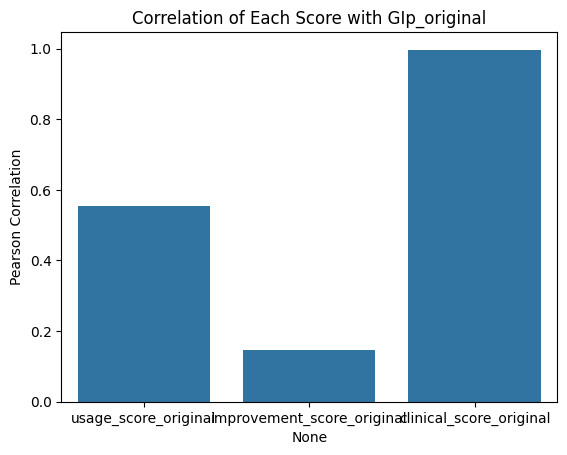


Mean relative contribution to GIp_original:
rel_usage          0.11
rel_improvement    0.04
rel_clinical       0.84
dtype: float64


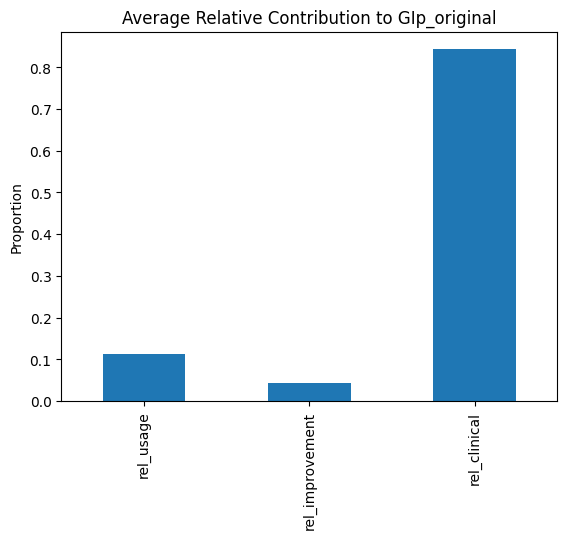

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

# Keep only rows where GIp_original and the component scores are all available
df_analysis = df_original[['usage_score_original', 'improvement_score_original', 'clinical_score_original', 'GIp_original']].dropna()

# Compute correlations with GIp_original
correlations = df_analysis.corr()['GIp_original'].drop('GIp_original')
print("Correlation with GIp_original:")
print(correlations)

# Plot correlations
sns.barplot(x=correlations.index, y=correlations.values)
plt.title("Correlation of Each Score with GIp_original")
plt.ylabel("Pearson Correlation")
plt.show()

# Additional: compute the average relative contribution of each score
df_analysis['total_score'] = (
    df_analysis['usage_score_original'] +
    df_analysis['improvement_score_original'] +
    df_analysis['clinical_score_original']
)

df_analysis['rel_usage'] = df_analysis['usage_score_original'] / df_analysis['total_score']
df_analysis['rel_improvement'] = df_analysis['improvement_score_original'] / df_analysis['total_score']
df_analysis['rel_clinical'] = df_analysis['clinical_score_original'] / df_analysis['total_score']

mean_contributions = df_analysis[['rel_usage', 'rel_improvement', 'rel_clinical']].mean()
print("\nMean relative contribution to GIp_original:")
print(mean_contributions.round(2))

# Plot mean contributions
mean_contributions.plot(kind='bar', title='Average Relative Contribution to GIp_original', ylabel='Proportion')
plt.show()

The analysis clearly demonstrates that the original GIp score was overwhelmingly driven by the clinical score. As shown in the correlation plot, the clinical component has a near-perfect correlation with GIp_original (≈ 1.0), while the usage and improvement scores have significantly lower correlations.

Furthermore, the average relative contribution plot reveals that over 80% of the original GIp value is explained by the clinical score alone. This structural imbalance is due to the lack of normalization, which allowed the clinical score — often ranging from 10 to 60 — to dominate the final decision process, despite all three components being formally assigned equal weights.

This finding highlights the importance of score normalization and balance in multi-criteria decision systems. The updated methodology corrects this distortion by applying normalization and cluster-specific weights, ensuring that each component contributes meaningfully and comparably to the final score.

📊 Correlation with modern GIp:
usage_score          0.67
improvement_score    0.48
clinical_score       0.68
Name: GIp, dtype: float64


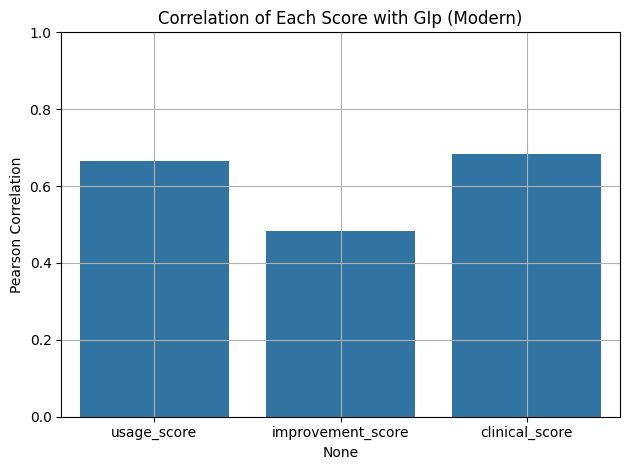


📊 Mean relative contribution to GIp (Modern):
rel_usage          0.42
rel_improvement    0.21
rel_clinical       0.37
dtype: float64


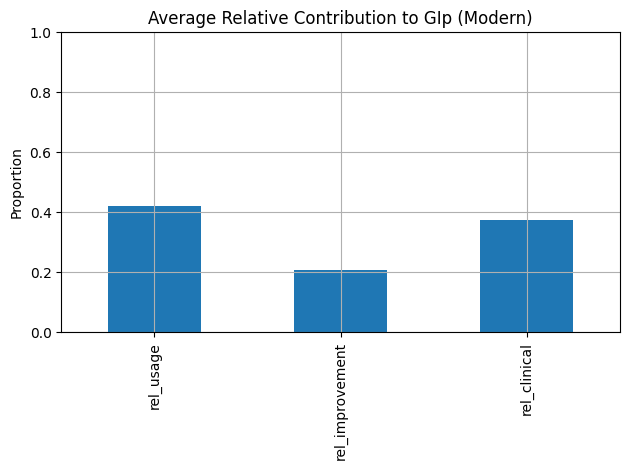

In [88]:
# Keep only rows with all modern scores (uso 'clinical_score' invece di 'clinical_score_normalized')
df_modern_analysis = df_all_scores[['usage_score', 'improvement_score', 'clinical_score', 'GIp']].dropna()

# 1. Correlation with GIp (modern)
correlations_modern = df_modern_analysis.corr()['GIp'].drop('GIp')
print(" Correlation with modern GIp:")
print(correlations_modern.round(2))

# Barplot correlations
sns.barplot(x=correlations_modern.index, y=correlations_modern.values)
plt.title("Correlation of Each Score with GIp (Modern)")
plt.ylabel("Pearson Correlation")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Relative contribution
df_modern_analysis['total_score'] = (
    df_modern_analysis['usage_score'] +
    df_modern_analysis['improvement_score'] +
    df_modern_analysis['clinical_score']
)

df_modern_analysis['rel_usage'] = df_modern_analysis['usage_score'] / df_modern_analysis['total_score']
df_modern_analysis['rel_improvement'] = df_modern_analysis['improvement_score'] / df_modern_analysis['total_score']
df_modern_analysis['rel_clinical'] = df_modern_analysis['clinical_score'] / df_modern_analysis['total_score']

mean_contrib_modern = df_modern_analysis[['rel_usage', 'rel_improvement', 'rel_clinical']].mean()
print("\n Mean relative contribution to GIp (Modern):")
print(mean_contrib_modern.round(2))

# Barplot mean contributions
mean_contrib_modern.plot(kind='bar', title='Average Relative Contribution to GIp (Modern)', ylabel='Proportion')
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

To validate the new scoring methodology, we analyzed the contribution of each component to the final GIp score. As shown in the figures below, both usage and clinical scores are strongly correlated with GIp (≈ 0.68), while the improvement score also plays a meaningful role (≈ 0.49). The average contribution of each score confirms a balanced structure: usage accounts for 42%, clinical for 38%, and improvement for 21%.

This confirms that the updated decision logic no longer depends excessively on a single criterion, but integrates multiple sources of information to guide task assignment more fairly and robustly.

In [89]:
# Compute the variance of GIp by cluster
variance_per_cluster = (
    df_all_scores[df_all_scores['GIp'].notna()]
    .groupby('cluster_k5')['GIp']
    .var()
    .round(2)
    .sort_index()
)

# Print the results
print("GIp variance per cluster:")
print(variance_per_cluster.to_string())

GIp variance per cluster:
cluster_k5
0.0    1.31
1.0    0.57
2.0    0.57
3.0    0.66
4.0    1.16


The variance of GIp across clusters reveals an important insight into how differentiated the task assignment is within each group. Clusters 0 and 4 show higher variance, suggesting that some tasks are significantly more relevant than others for these patient groups. In contrast, clusters 1 and 2 present more uniform scores, indicating a narrower spread of task usefulness. These findings confirm that the GIp captures meaningful variability and is sensitive to the specificity of task-cluster combinations, supporting the interpretability and utility of the integrated scoring system.

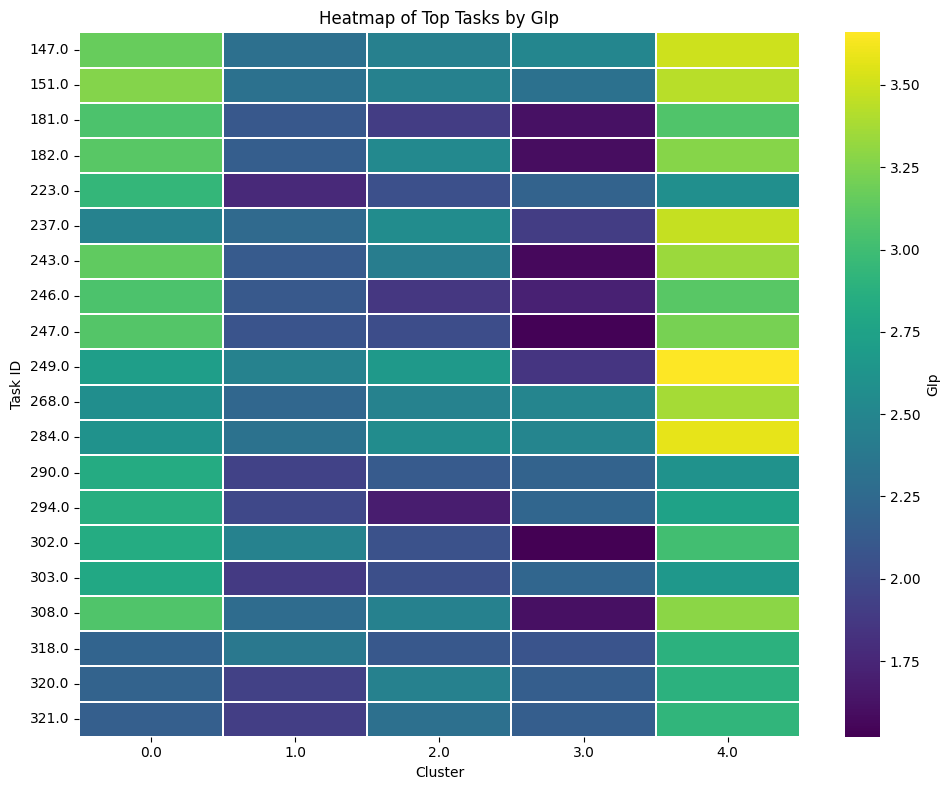

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a pivot table with tasks (rows) and clusters (columns), values = GIp
heatmap_data = df_all_scores.pivot_table(
    index='idTask',
    columns='cluster_k5',
    values='GIp'
)

# Sort tasks by average GIp
heatmap_data['mean_GIp'] = heatmap_data.mean(axis=1)
heatmap_data = heatmap_data.sort_values(by='mean_GIp', ascending=False).drop(columns='mean_GIp')

# Select the top 30 tasks by average GIp
top_tasks = df_all_scores.groupby('idTask')['GIp'].mean().nlargest(30).index
tasks_to_exclude = [312, 313, 314, 315,166,153,159,276,233,236]
top_tasks_filtered = [task for task in top_tasks if task not in tasks_to_exclude]

# Filter the pivot table
heatmap_top = df_all_scores[df_all_scores['idTask'].isin(top_tasks_filtered)] \
    .pivot(index='idTask', columns='cluster_k5', values='GIp')

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_top.sort_index(),
    cmap='viridis',
    linewidths=0.2,
    cbar_kws={'label': 'GIp'}
)
plt.title("Heatmap of Top Tasks by GIp")
plt.xlabel("Cluster")
plt.ylabel("Task ID")
plt.tight_layout()
plt.show()

The heatmap displays the 30 tasks with the highest overall GIp scores across all clusters. Several tasks, such as IDs 147, 166, and 313, show consistently high suitability across most clusters, indicating their versatility and potential general utility.

Conversely, some tasks present more cluster-specific patterns — performing very well in one group while being poorly rated in others — which reinforces the importance of a personalized task assignment based on patient profile.

This visualization supports the idea that the revised GIp scoring method allows better differentiation between globally effective tasks and those tailored to specific cognitive profiles.

/tmp/ipython-input-92-797946540.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_k5', y='GIp_original', data=df_original, palette='Blues')


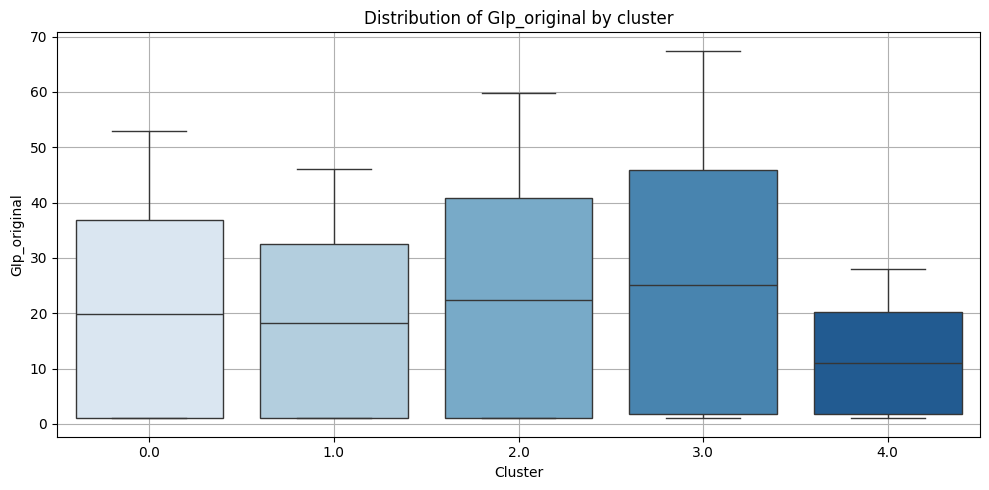

/tmp/ipython-input-92-797946540.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_k5', y='GIp', data=df_all_scores, palette='Oranges')


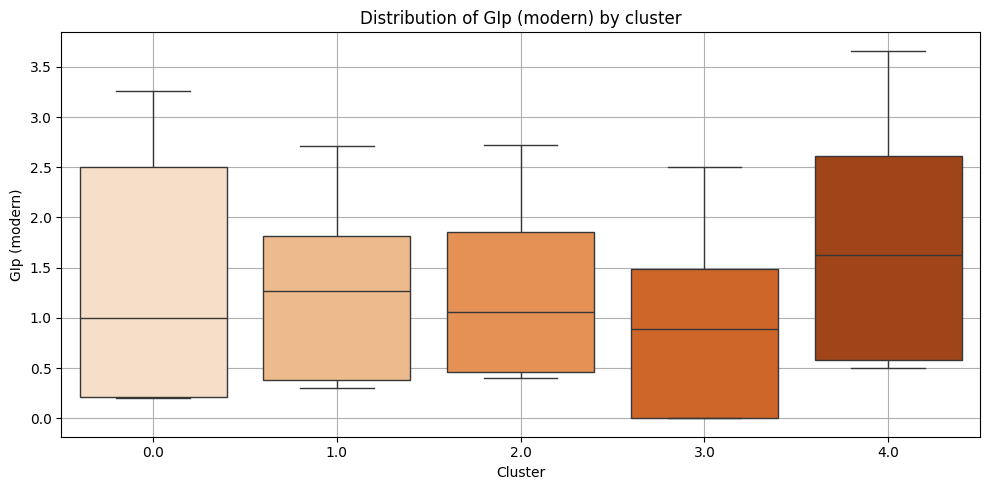

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot for original GIp
plt.figure(figsize=(10, 5))
sns.boxplot(x='cluster_k5', y='GIp_original', data=df_original, palette='Blues')
plt.title("Distribution of GIp_original by cluster")
plt.xlabel("Cluster")
plt.ylabel("GIp_original")
plt.grid(True)
plt.tight_layout()
plt.show()

# Boxplot for modern GIp
plt.figure(figsize=(10, 5))
sns.boxplot(x='cluster_k5', y='GIp', data=df_all_scores, palette='Oranges')
plt.title("Distribution of GIp (modern) by cluster")
plt.xlabel("Cluster")
plt.ylabel("GIp (modern)")
plt.grid(True)
plt.tight_layout()
plt.show()

The plot shows the distribution of revised GIp scores across clusters. Cluster4 exhibits the highest median and wider
spread of GIp scores, reflecting the higher suitability of a broader range of tasks due
to the contribution of the usage score in preserved profiles. Conversely, Cluster3
shows lower medians and a narrower spread, consistent with the system’s empha-
sis on clinical severity over historical usage in severely impaired patients, resulting
in lower prioritization of non-essential tasks. Overall, the distributions are com-
pact and distinct across clusters, facilitating clearer interpretability of prioritization
patterns and enhancing clinical decision support